# 1.- Definiciones iniciales

En primer lugar, se importan todas las librerías que se utilizarán.

In [1]:
from pprint import pprint
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import scipy
from sklearn.metrics import mean_squared_error

A continuación, se declaran algunas funciones que serán útiles a la hora de mostrar los resultados.

La función ```join_plot``` realiza gráficas de manera conjunta de los datos contenidos en el parámetro ```array_plot```. Este parámetro es una lista de arrays, donde las columnas de cada array serán ploteadas en gráficas distinta. Si la lista tiene más de un array, las gráficas de los elementos de la lista serán supuerpuestas unas con otras.

In [2]:
def join_plot(array_plot,plot_names,labels,y_label='',x_label='Tiempo [s]',
              main_title='',zoom=[0,0],layout='normal'):
    nro_curves, data_len, nro_plot = array_plot.shape
    if zoom == [0,0]:
        x_axis = np.linspace(0, data_len-1, data_len).astype(np.int)
    else:
        zoom = np.array(zoom)
        x_axis = np.linspace(zoom[0], zoom[1], zoom[1]+1).astype(np.int)
        
    if layout == 'thin':
        fig, axs = plt.subplots(3, 1,figsize=(15,10))
    else:
        fig, axs = plt.subplots(3, 1,figsize=(15,25))
        
    if main_title != '':
        fig.suptitle(main_title, fontsize=20)
    
    for i in range(nro_plot):
        for j in range(nro_curves):
            data = array_plot[j][:,i]
            axs[i].plot(x_axis, data[x_axis],ls='solid', linewidth=3, label=labels[j], alpha=0.7)
            axs[i].set_title(plot_names[i], fontsize=16)   
            axs[i].set_xlabel(x_label, fontsize=12) 
            axs[i].set_ylabel(y_label, fontsize=12)
            axs[i].legend(loc='upper right') 
    fig.subplots_adjust(hspace=.4)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

#### RMSE: Root Mean Square Error (Error cuadrático medio)

La siguiente función se utiliza para calcular el RMSE entre dos conjuntos de vectores.

<img src="./img/rmse.png" alt="rmse" style="width: 200px;"/>

Este indicador es útil para comparar errores entre mediciones con igual unidad.
En la implementación se utiliza la función `mean_squared_error` de la librería `sklearn.metrics`. Por defecto, el parámetro `squared` esta seteado en `True` y la función rentorna el MSE. Si se lo establece en `false`, el resultado es el RMSE.

In [3]:
def rmse(real,predic):
    return mean_squared_error(real, predic, squared=False)

# 2.- Implementación del filtro de Kalman

La función ```kalman``` implementa el filtro de Kalman sobre los datos medidos en los parámetros ```noise_pos``` y ```noise_vel```. Las matrices A, C, Q y R son pasadas como parámetros al filtro, asi como también las mediciones iniciales x0 y el estado inicial de la matriz de covariancia de medición P0.

La función de desarrolla dentro de un ciclo `for`, en donde se procesa cada medición. En primer lugar, en cada instante de tiempo, se define el vector de mediciones Z. Si el vector ```noise_vel``` esta vacío, sólo se toman mediciones de posición, por lo que el vector de mediciones Z tendrá la forma: ```Z = [pos_x, pos_y, pos_z]```. Si se añaden mediciones de velocidad, el vector de mediciones es: ```Z = [pos_x, vel_x, pos_y, vel_y, pos_z, vel_z]```.

Luego, el filtro opera en dos ciclos. El primero es el ciclo de predicción, que utiliza la matriz del sistema A y la covariancia del ruido Q. El segundo es el ciclo de actualización de medición, que utiliza la ganancia de kalman K y el error en la predicción en el instante de tiempo anterior. 

Finalmente, los valores estimados se almacenan en vectores y son devueltos por la funcion.



In [4]:
def kalman(A, C, Q, R, x0, P0, noise_pos, noise_vel=[]):
    
    # Inicializar variables útiles
    x_tot = [] # Vector que almacena todas las mediciones
    p_tot = [] # Vector que almacena todas las covariancias
    x = x0     # Medición inicial
    P = P0     # Matriz de covariancia inicial

    I = np.identity(C.shape[1]) # Matriz de identidad
    
    # Se procesa cada medición n dentro de los vectores noise_pos y noise_vel
    for n in range(len(noise_pos)):
        
        # Se arma el vector de mediciones Z, dependiendo si hay o no mediciones de velocidad.
        if len(noise_vel) == 0:
            # Z = [pos_x, pos_y, pos_z]
            Z = np.array(noise_pos[n]) # Vector de mediciones
        else:
            # Z = [pos_x, vel_x, pos_y, vel_y, pos_z, vel_z]
            Z = np.zeros(len(noise_pos[n])+len(noise_pos[n])) # Vector de mediciones
            for i in range(len(Z)//2):
                Z[i*2] = np.array(noise_pos[n][i])
                Z[i*2+1] = np.array(noise_vel[n][i])
                
        # Ciclo de predicción
        x = (A @ x)                     # Actualización de predicción
        P = A @ P @ A.T + Q             # Covariancia de medición
        
        # Se almacenan resultados
        x_tot.append(x)
        p_tot.append(P)
        
        # Ciclo de actualización de medición
        y = Z - (C @ x)                 # Cálculo de error entre medición y estimación
        S = C @ P @ C.T + R
        K = P @ C.T @ np.linalg.inv(S)  # Ganancia de kalman
        x = x + (K @ y)                 # Actualización de mediciones
        
        P = (I - K @ C) @ P             # Covariancia de medicion   
        
    
    # Se arman y devuelven los vectores de posición, velocidad y aceleración.
    x_tot = np.array(x_tot)
    p_tot = np.array(p_tot)
    
    pos_tot = x_tot[:,0:9:3] # Posición estimada
    vel_tot = x_tot[:,1:9:3] # Velocidad estimada
    ace_tot = x_tot[:,2:9:3] # Aceleración estimada
    
    return pos_tot, vel_tot, ace_tot

Algunas de las matrices que se utilizan en el filtro de Kalman dependen sólo del modelo del sistema, o de las características de los sensores utilizados. Estas matrices no serán modificadas a lo largo del trabajo y es por eso que podemos definirlas en esta sección de manera global.

In [5]:
# Mediciones iniciales x0 = [pos_x, vel_x, ace_x, pos_y, vel_y, ace_y, pos_z, vel_z, ace_z]
x0 = np.array([10.7533, 1.1009, -5.7247, 36.6777, -17, 3.4268, -45.1769, 35.7418, 5.2774]).T

# Incerteza inicial P0 = [pos_x, vel_x, ace_x, pos_y, vel_y, ace_y, pos_z, vel_z, ace_z]
P0 = np.diag([100, 1, .01, 100, 1, .01, 100, 1, .01])

# Matriz del sistema
h = 1. # delta_t
a_aux = np.array([[1.,h,(h**2)/2.],[0.,1.,h],[0.,0.,1.]])
zeros3 = np.zeros([3,3])
A = np.vstack([np.hstack([a_aux, zeros3, zeros3]), 
               np.hstack([zeros3, a_aux, zeros3]), 
               np.hstack([zeros3, zeros3, a_aux])])

# Covariancia de medición
Q = .3 * np.identity(9)
print('A =')
print(A)
print('Q =')
print(Q)

A =
[[1.  1.  0.5 0.  0.  0.  0.  0.  0. ]
 [0.  1.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  1.  0.5 0.  0.  0. ]
 [0.  0.  0.  0.  1.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.  1.  0.5]
 [0.  0.  0.  0.  0.  0.  0.  1.  1. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  1. ]]
Q =
[[0.3 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.3 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.3 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.3 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.3 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.3 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.3 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.3 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.3]]


# 3.- Carga de datos

Los datos son cargados utilizando al librería "Pandas", de los archivos *posicion.dat*, *velocidad.dat* y *aceleracion.dat*. Luego se transforman en objetos "numpy" para facilitar su operación.

In [6]:
col_names = ['x','y','z']
data_pos = pd.read_csv("./data/posicion.dat", sep=' ', names = col_names)
data_vel = pd.read_csv("./data/velocidad.dat", sep=' ', names = col_names)
data_ace = pd.read_csv("./data/aceleracion.dat", sep=' ', names = col_names)

In [7]:
print('Cantidad de datos por coordenada = ' + str(len(data_pos.index)))
data_pos.head()

Cantidad de datos por coordenada = 351


x          y           z
0   0.000000   0.000000    0.000000
1  -2.504231 -15.694906   39.450869
2 -10.103812 -28.431511   83.470978
3 -22.212787 -38.644100  131.710029
4 -38.245201 -46.766958  183.817725

In [8]:
pos = data_pos.to_numpy() # Valor real de la posición
vel = data_vel.to_numpy() # Valor real de la velocidad
ace = data_ace.to_numpy() # Valor real de la aceleración

# 4.- Generación de mediciones con ruido

En esta sección se crean las mediciones con ruido superpuesto a la posición y velocidad

### 4.1.- Agregado de ruido gaussiano a la posición

Mediante el uso de la función ```random.normal``` se genera un conjunto de datos con distribución gaussiana, de media 0 y desviación estandar 10. Los datos se almacenan en una matriz con las mismas dimensiones que el vector de posiciones cargado previamente (es decir 3x351).
Luego, se muestra el histograma de la distribución del ruido. 

Finalmente, el ruido es añadido a la matriz de datos de posiciones suamando ambas matrices. Se grafica el resultado para cada eje, con zoom en el rango de tiempo [10,60].

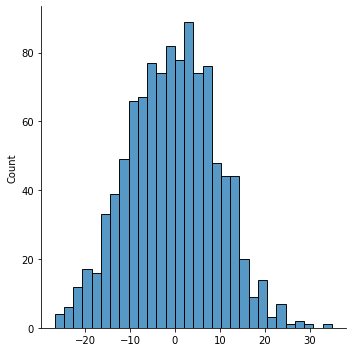

In [9]:
noise_gauss_u_pos = 0   # Media del ruido gaussiano para la posición
noise_gauss_d_pos = 10  # Desviación estandar del ruido gaussiano
noise_gauss_pos = np.random.normal(noise_gauss_u_pos,noise_gauss_d_pos,pos.shape)
sns.displot(noise_gauss_pos.reshape(-1),bins=30)

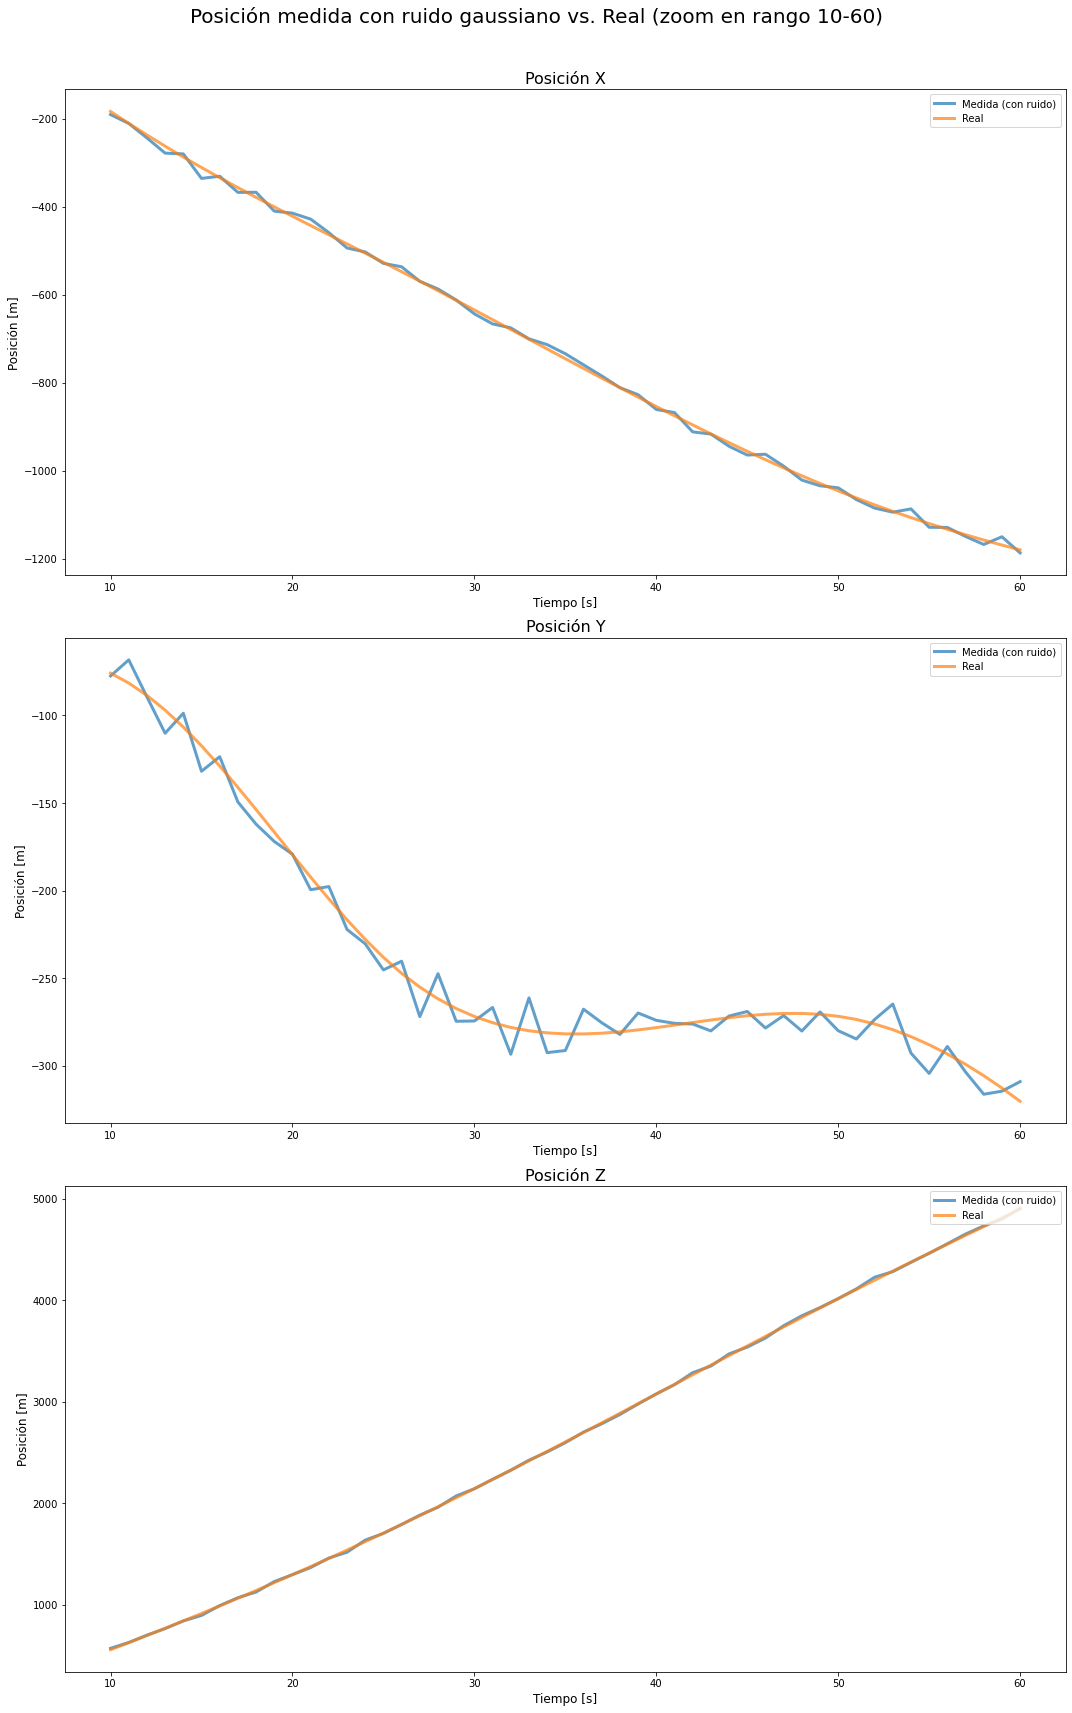

In [10]:
pos_noise_gauss = pos + noise_gauss_pos

join_plot(np.array([pos_noise_gauss,pos]),
            plot_names=['Posición X','Posición Y','Posición Z'],
            y_label='Posición [m]',
            labels=['Medida (con ruido)','Real'],
            main_title='Posición medida con ruido gaussiano vs. Real (zoom en rango 10-60)',
            zoom=[10,60]
           )

### 4.2.- Agregado de ruido uniforme a la posición

En este caso, se utiliza la función ```random.uniform``` para generar los vectores de ruido uniforme. Los parámetros que recibe esta función son los extremos [a,b] del intervalo. La variancia en la distribución uniforme, viene dada por:
<img src="./img/v_uniform.png" alt="uniform" style="width: 100px;"/>

Por lo tanto, sabiendo el valor de la variancia podemos despejar el ancho del intervalo [a,b]. Luego, se dibuja el histograma y se agrega el ruido a la matriz de datos de posiciones.

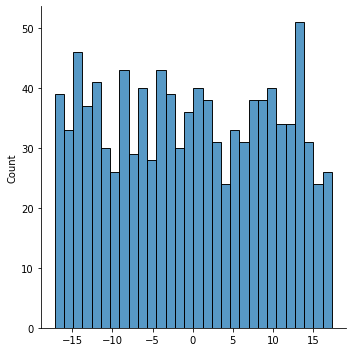

In [11]:
noise_uniform_pos_d = 10
interval =  np.sqrt((noise_uniform_pos_d**2)*12)
noise_uniform_pos = np.random.uniform(-interval/2,interval/2,pos.shape)
sns.displot(noise_uniform_pos.reshape(-1),bins=30)

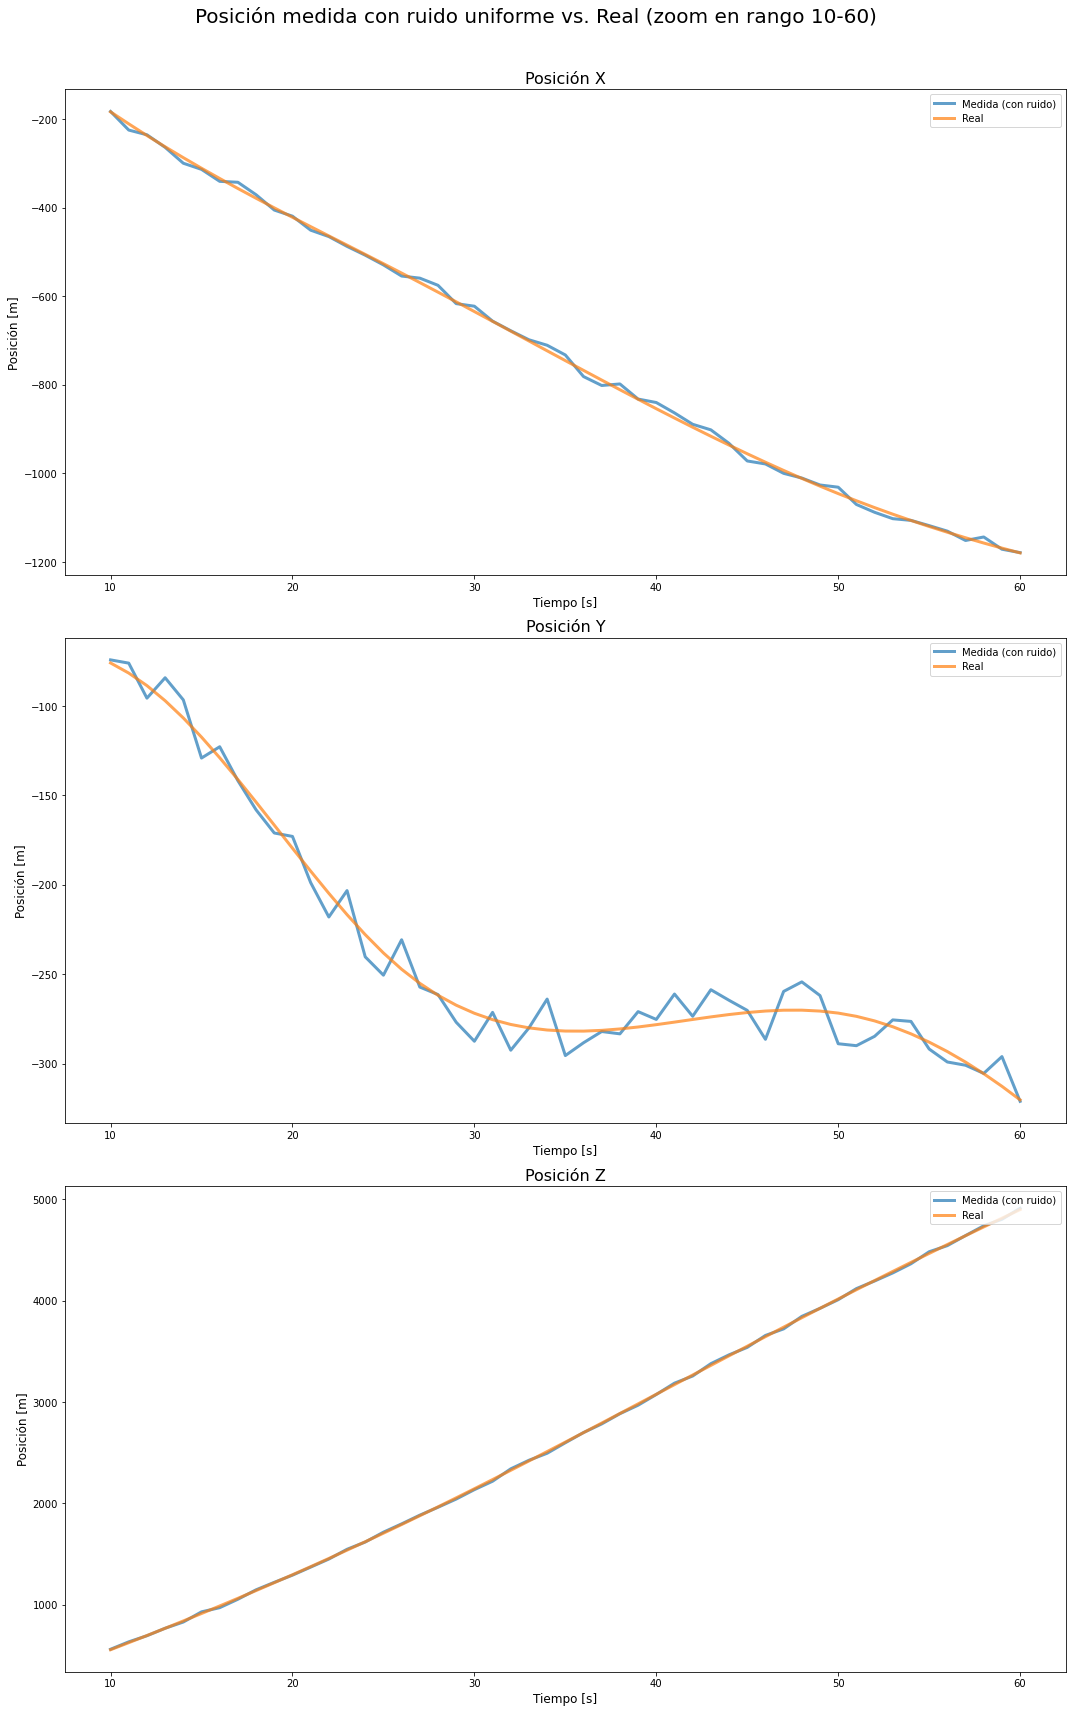

In [12]:
pos_noise_uniform = pos + noise_uniform_pos

join_plot(np.array([pos_noise_uniform,pos]),
            plot_names=['Posición X','Posición Y','Posición Z'],
            y_label='Posición [m]',
            labels=['Medida (con ruido)','Real'],
            main_title='Posición medida con ruido uniforme vs. Real (zoom en rango 10-60)',
            zoom=[10,60]
           )

### 4.3.- Agregado de ruido gaussiano a la velocidad

De manera similar al punto 4.1 se genera una matriz de ruido gaussiano y se agrega a las mediciones de velocidad.

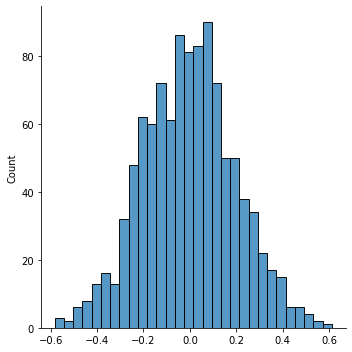

In [13]:
noise_gauss_u_vel = 0
noise_gauss_d_vel = .2
noise_gauss_vel = np.random.normal(noise_gauss_u_vel,noise_gauss_d_vel,pos.shape)
sns.displot(noise_gauss_vel.reshape(-1),bins=30)

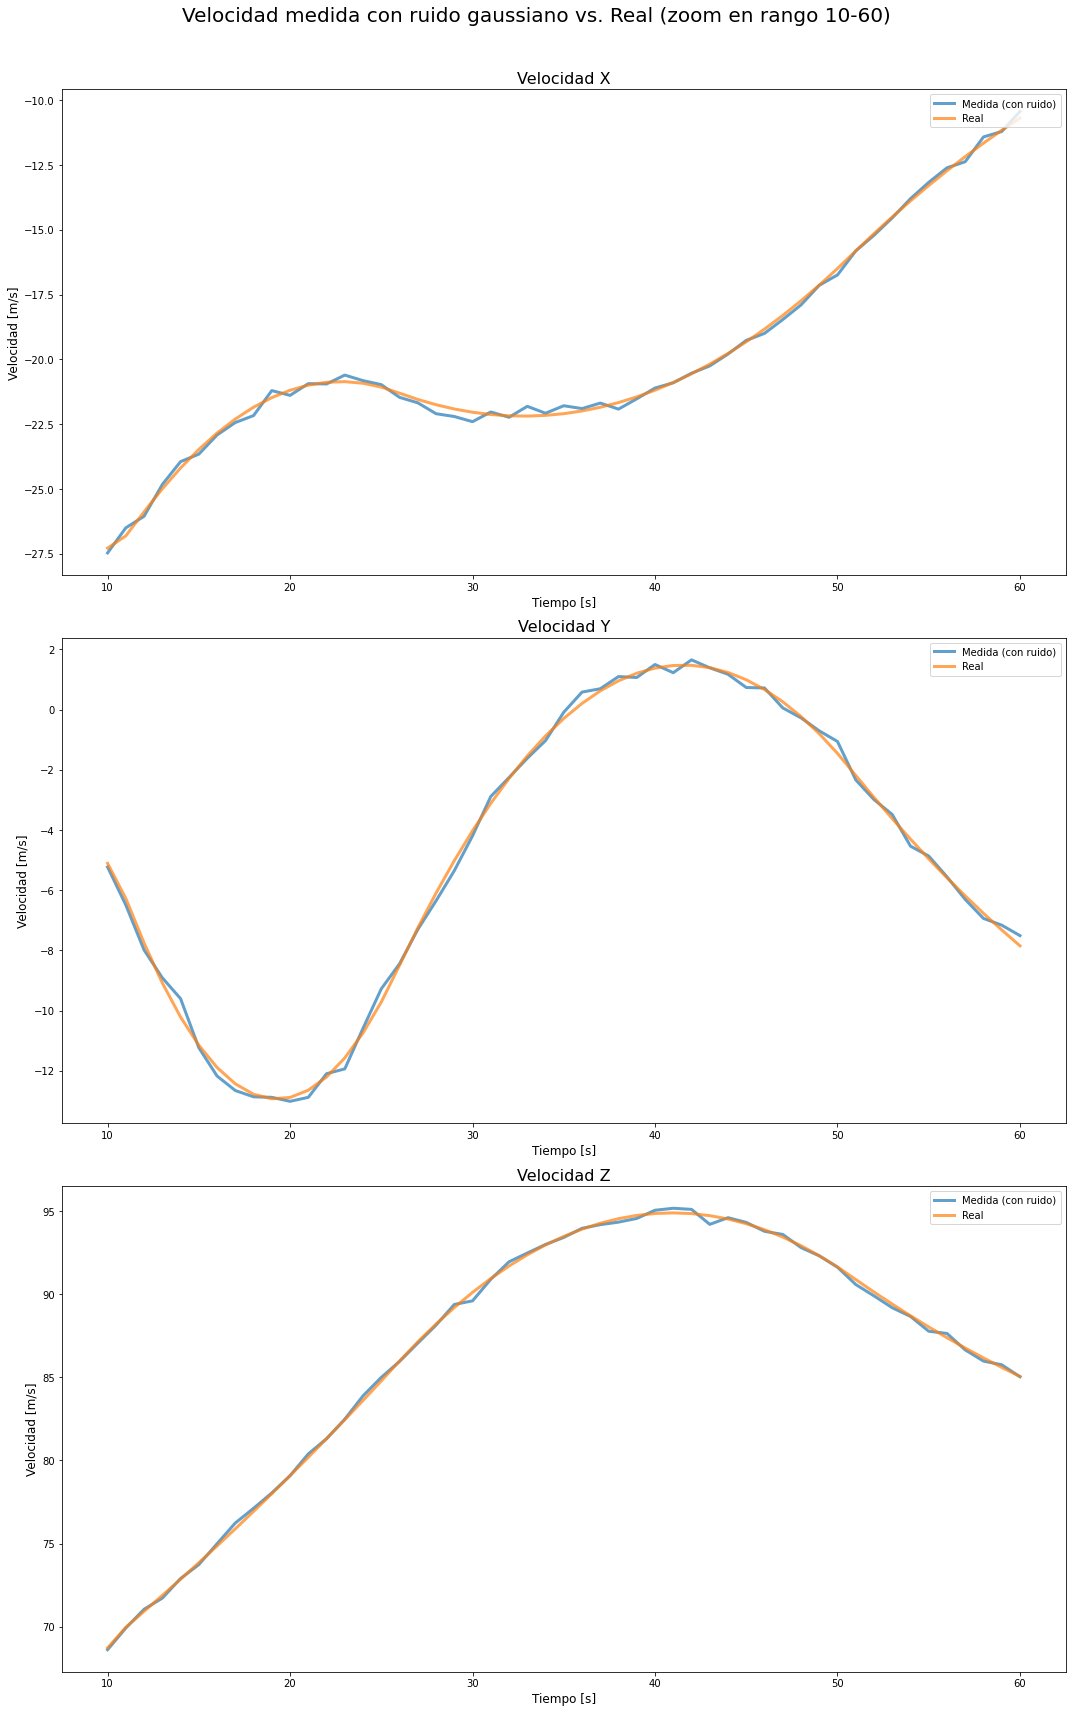

In [14]:
vel_noise_gauss = vel + noise_gauss_vel

join_plot(np.array([vel_noise_gauss,vel]),
            plot_names=['Velocidad X','Velocidad Y','Velocidad Z'],
            y_label='Velocidad [m/s]',
            labels=['Medida (con ruido)','Real'],
            main_title='Velocidad medida con ruido gaussiano vs. Real (zoom en rango 10-60)',
            zoom=[10,60]
           )

# 5.- Aplicación del filtro de Kalman

### 5.1.- Estimaciones con medición de posición con ruido gaussiano

Antes de generar las estimaciones se deben definir las matrices C y R, que dependen de cada caso en particular. 

R es la matriz de covarianza del ruido y representa la incertidumbre en las mediciones de posición. Dado que el ruido en cada eje no está correlacionado con los demás, los términos de covariancias son nulos y R adquiere una estructura diagonal. Los valores de la diagonal son las variancias del ruido en cada eje (en este caso 100).

Por su parte, C es la matriz de obsevación. Es una matriz formada principalmente por ceros, donde los unos nos indican que valores están siendo medidos. En este caso, las mediciones observadas serán las posiciones en cada eje de coordenadas. Tener en cuenta que el vector de estados tiene la forma:

```x0 = [pos_x, vel_x, ace_x, pos_y, vel_y, ace_y, pos_z, vel_z, ace_z]```

Finalmente, las matrices y las mediciones son pasadas como parámetro a la función ```kalman()``` definida previamente, que retorna las predicciones de posición, velocidad y aceleración. Además, las estimaciones son graficadas y contrastadas con los valores reales

In [15]:
# Matriz de obsevación
C = np.zeros([3,9])
for i in range(3):
    C[i,3*i] = 1
print('C =')
print(C)
    
# Incerteza en las mediciones (covariancia del error en las mediciones)
R = np.diag([noise_gauss_d_pos**2, noise_gauss_d_pos**2, noise_gauss_d_pos**2])
print('R =')
print(R)

C =
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]]
R =
[[100   0   0]
 [  0 100   0]
 [  0   0 100]]


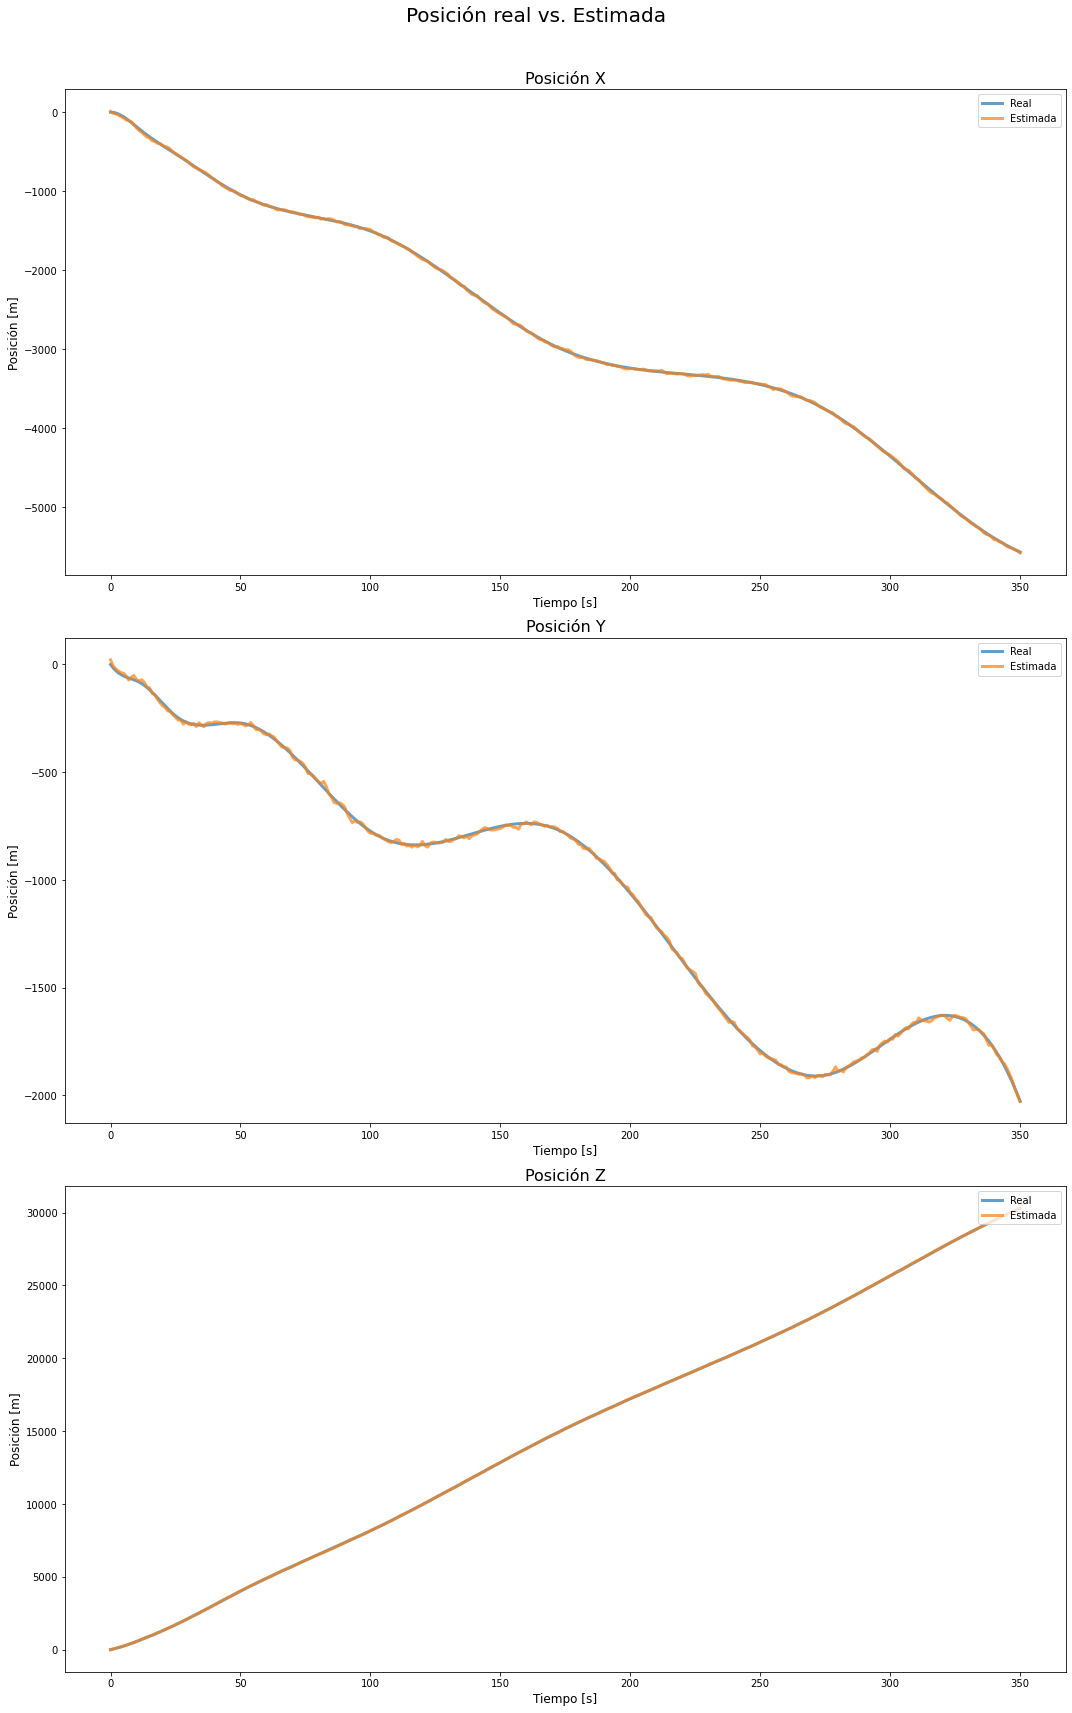

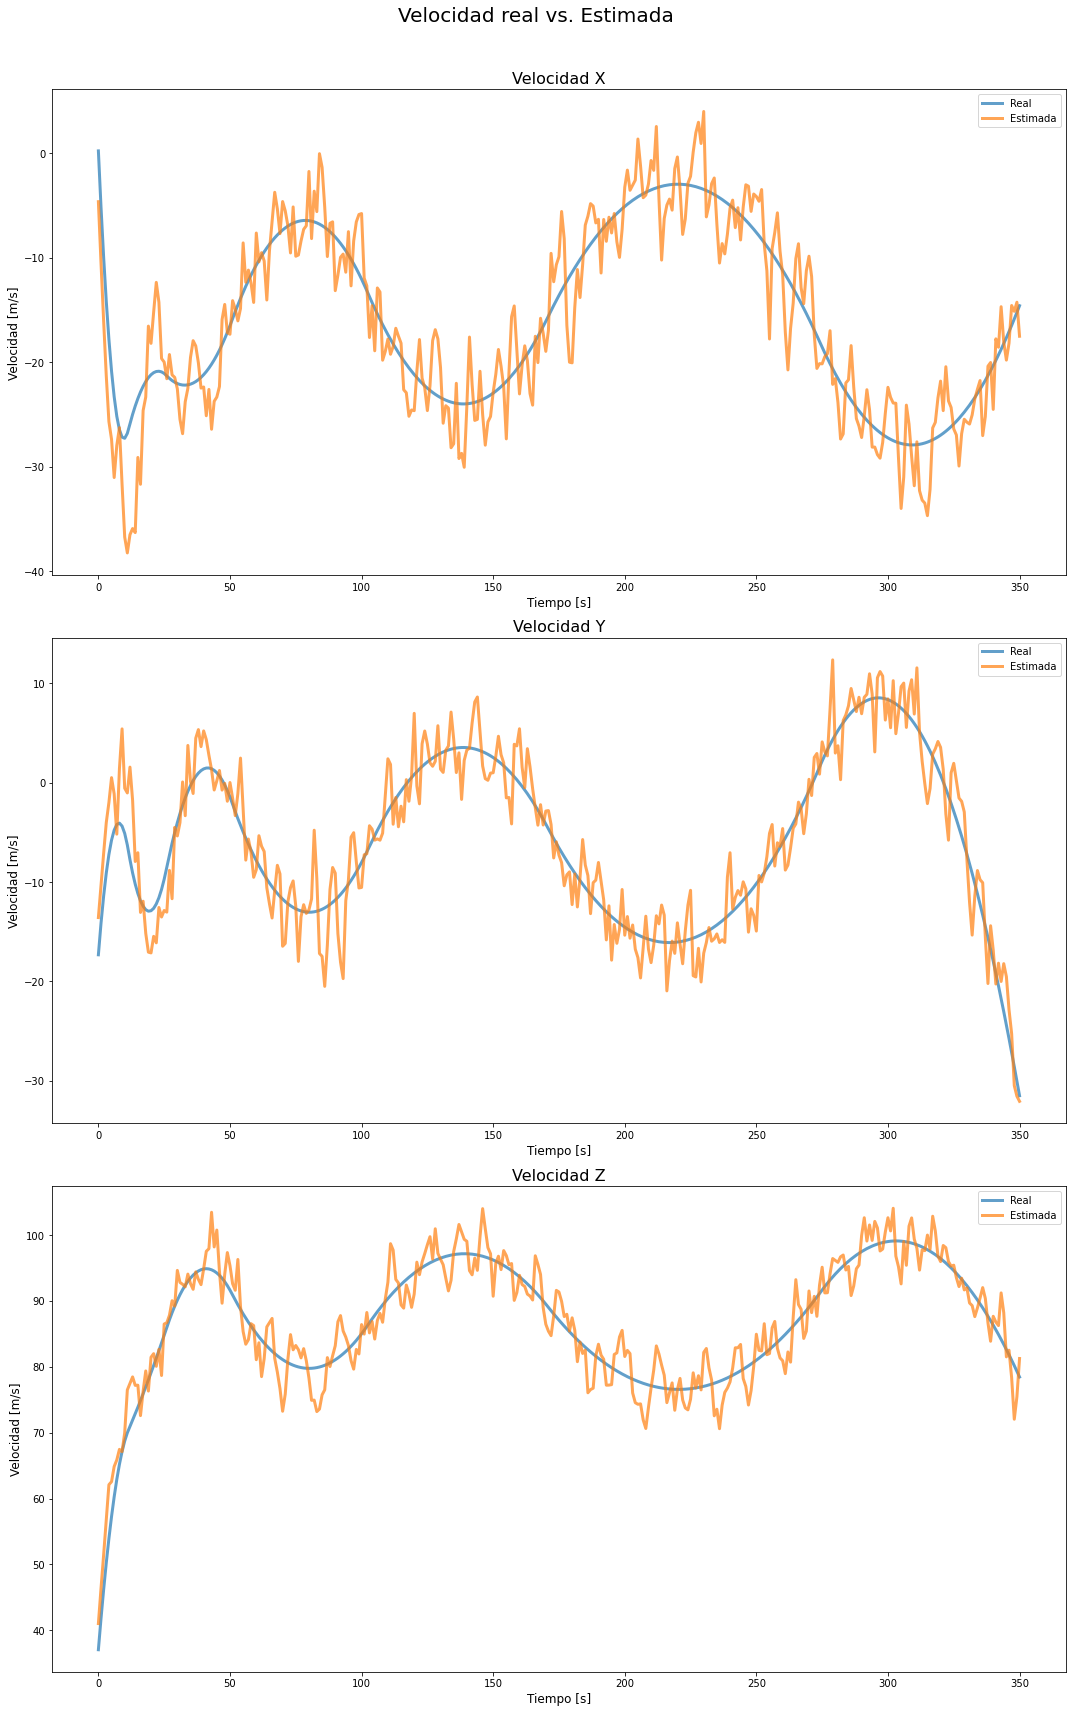

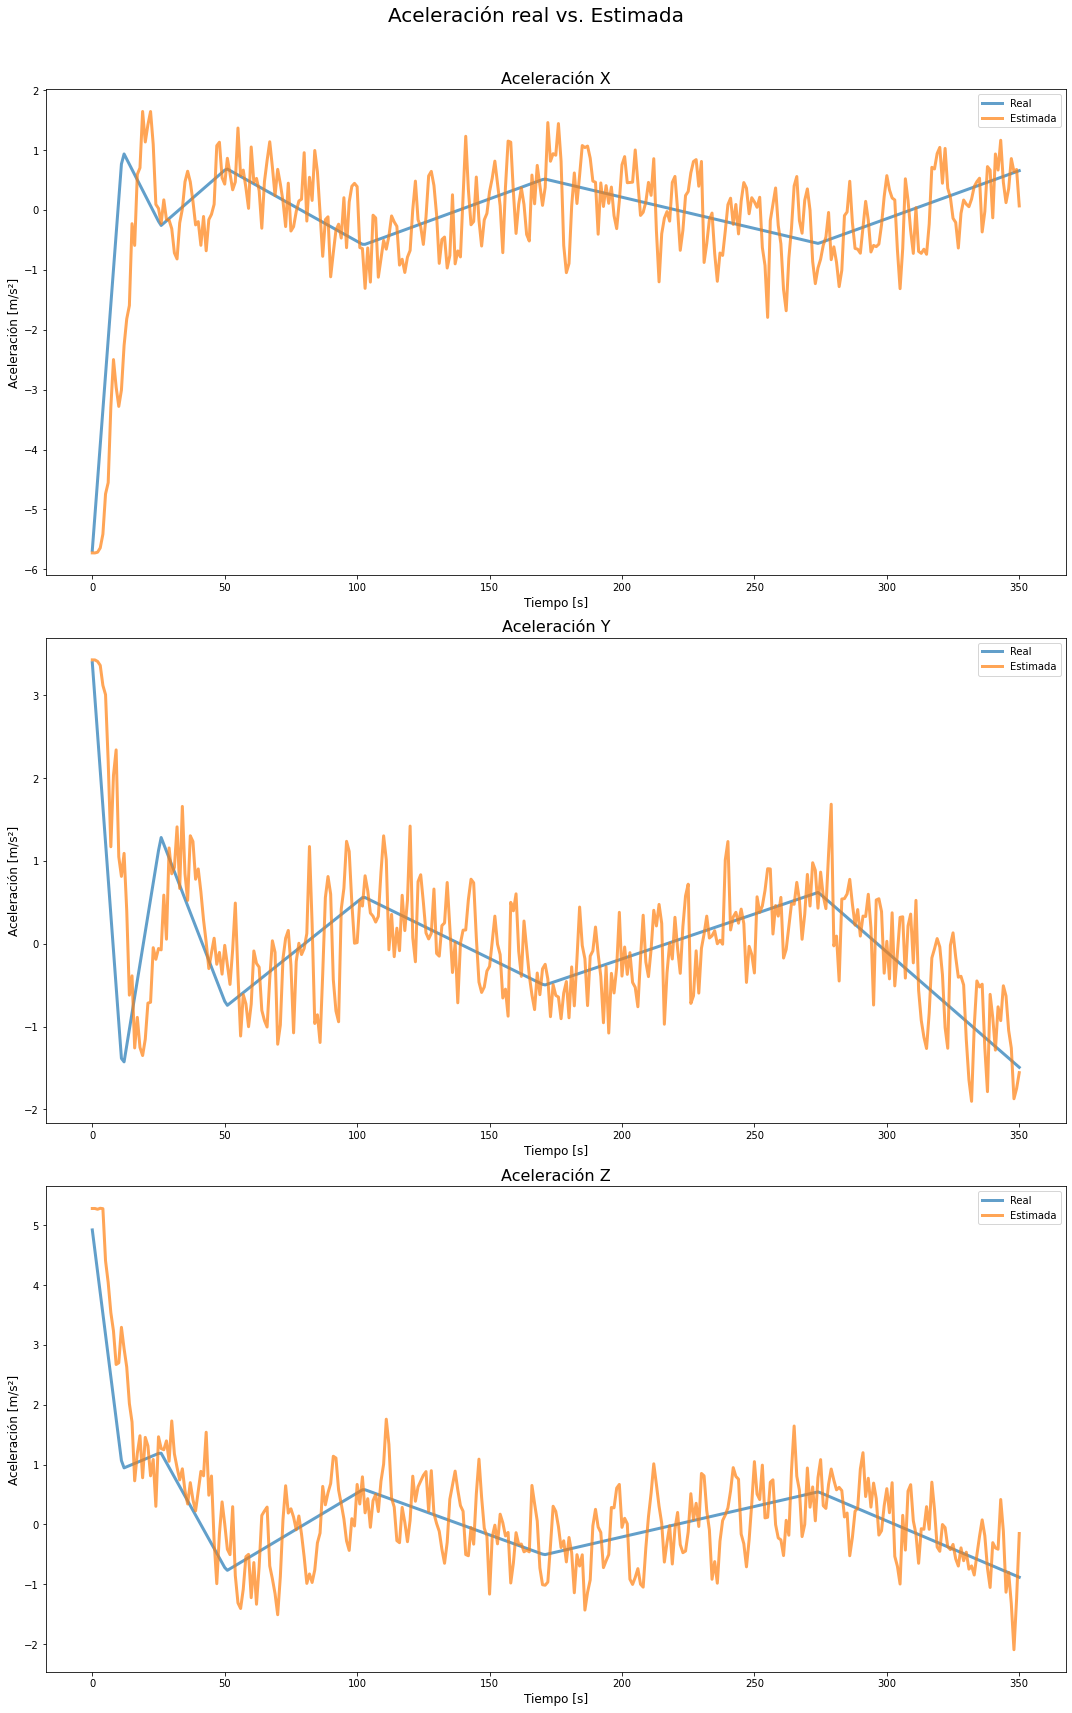

In [16]:
pos_pred_gauss, vel_pred_gauss, ace_pred_gauss = kalman(A, C, Q, R, x0, P0, pos_noise_gauss)

join_plot(np.array([pos,pos_pred_gauss]),
            plot_names=['Posición X','Posición Y','Posición Z'],
            y_label='Posición [m]',
            labels=['Real','Estimada'],
            main_title='Posición real vs. Estimada')

join_plot(np.array([vel,vel_pred_gauss]),
            plot_names=['Velocidad X','Velocidad Y','Velocidad Z'],
            y_label='Velocidad [m/s]',
            labels=['Real','Estimada'],
            main_title='Velocidad real vs. Estimada',
           )

join_plot(np.array([ace,ace_pred_gauss]),
            plot_names=['Aceleración X','Aceleración Y','Aceleración Z'],
            y_label='Aceleración [m/s²]',
            labels=['Real','Estimada'],
            main_title='Aceleración real vs. Estimada')

### 5.2.- Estimaciones con medición de posición con ruido uniforme

Se repiten los pasos realizados en el apartado anterior. Dado que las mediciones y el vector de estados son idénticos al apartado anterior, la matriz de observación C no se modifica. De igual forma, si bien el ruido tiene otra distribución, su variancia sigue manteniendo el mismo valor, por lo que la matriz R también coincide con la definida previamente.

In [17]:
# Matriz de obsevación
C = np.zeros([3,9])
for i in range(3):
   C[i,3*i] = 1
print('C =')
print(C)

# Incerteza en las mediciones (covariancia del error en las mediciones)
R = np.diag([noise_uniform_pos_d**2, noise_uniform_pos_d**2, noise_uniform_pos_d**2])
print('R = ')
print(R)


C =
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]]
R = 
[[100   0   0]
 [  0 100   0]
 [  0   0 100]]


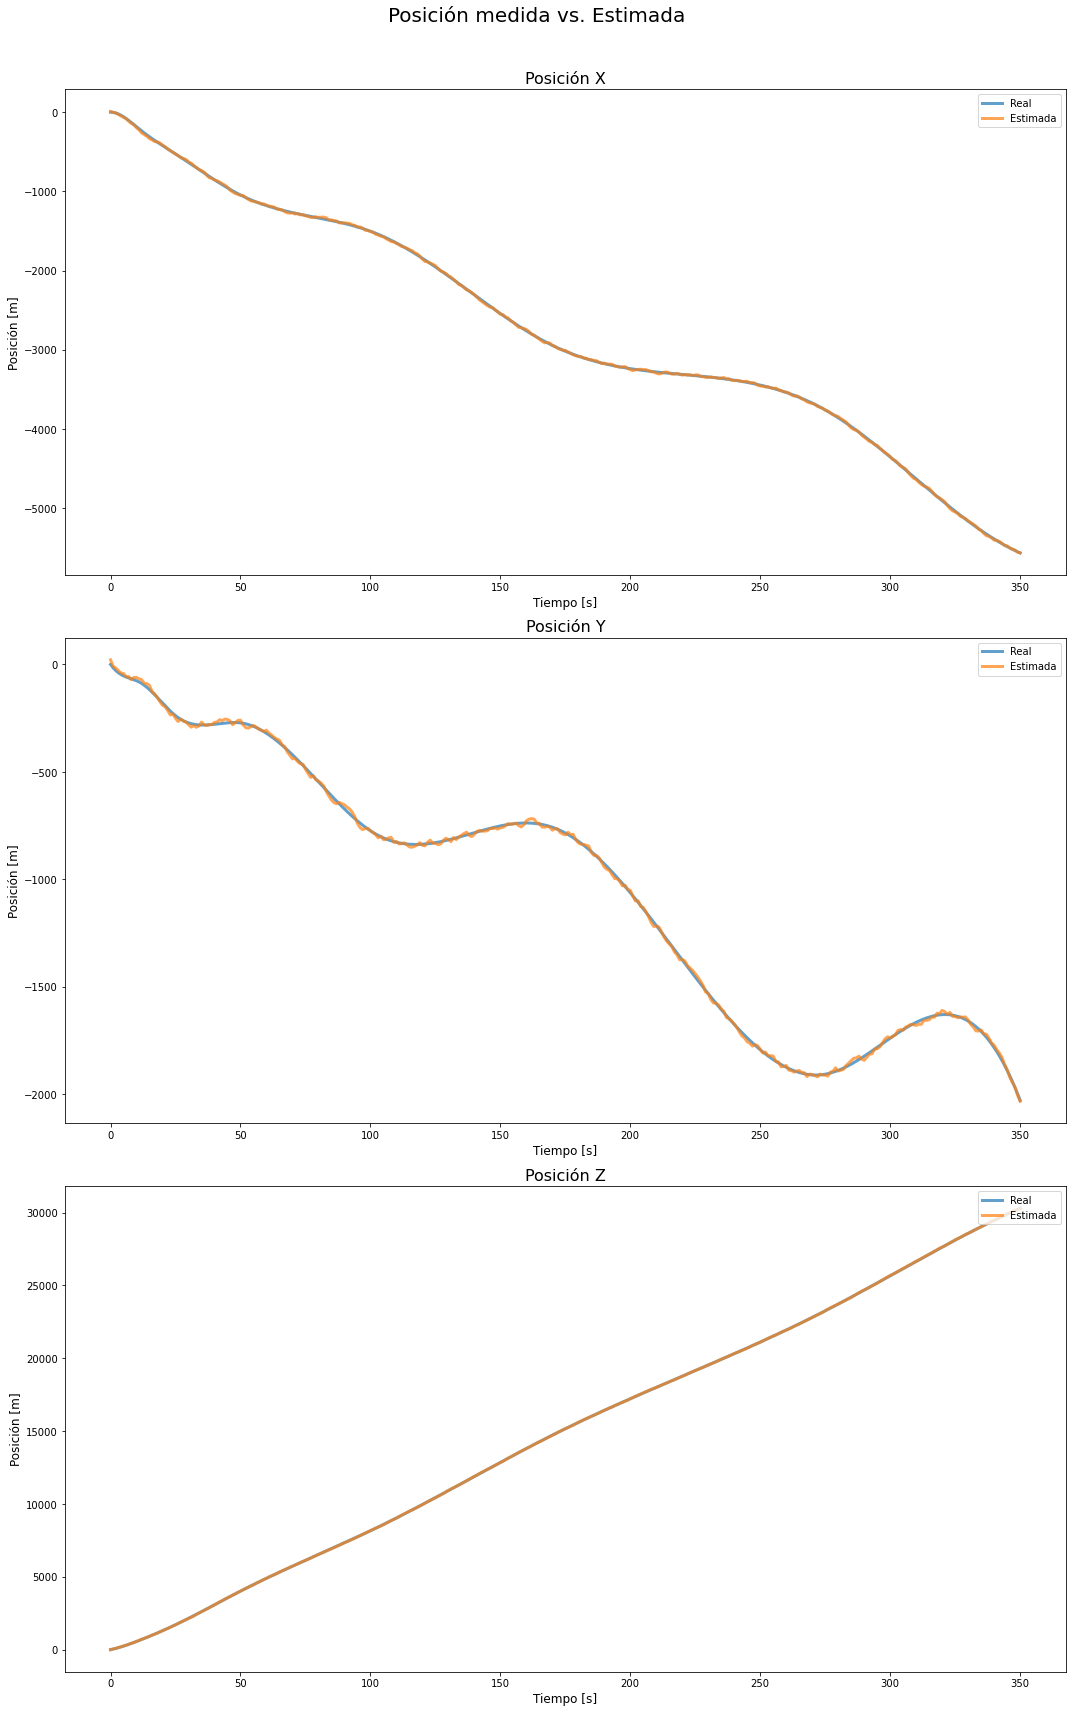

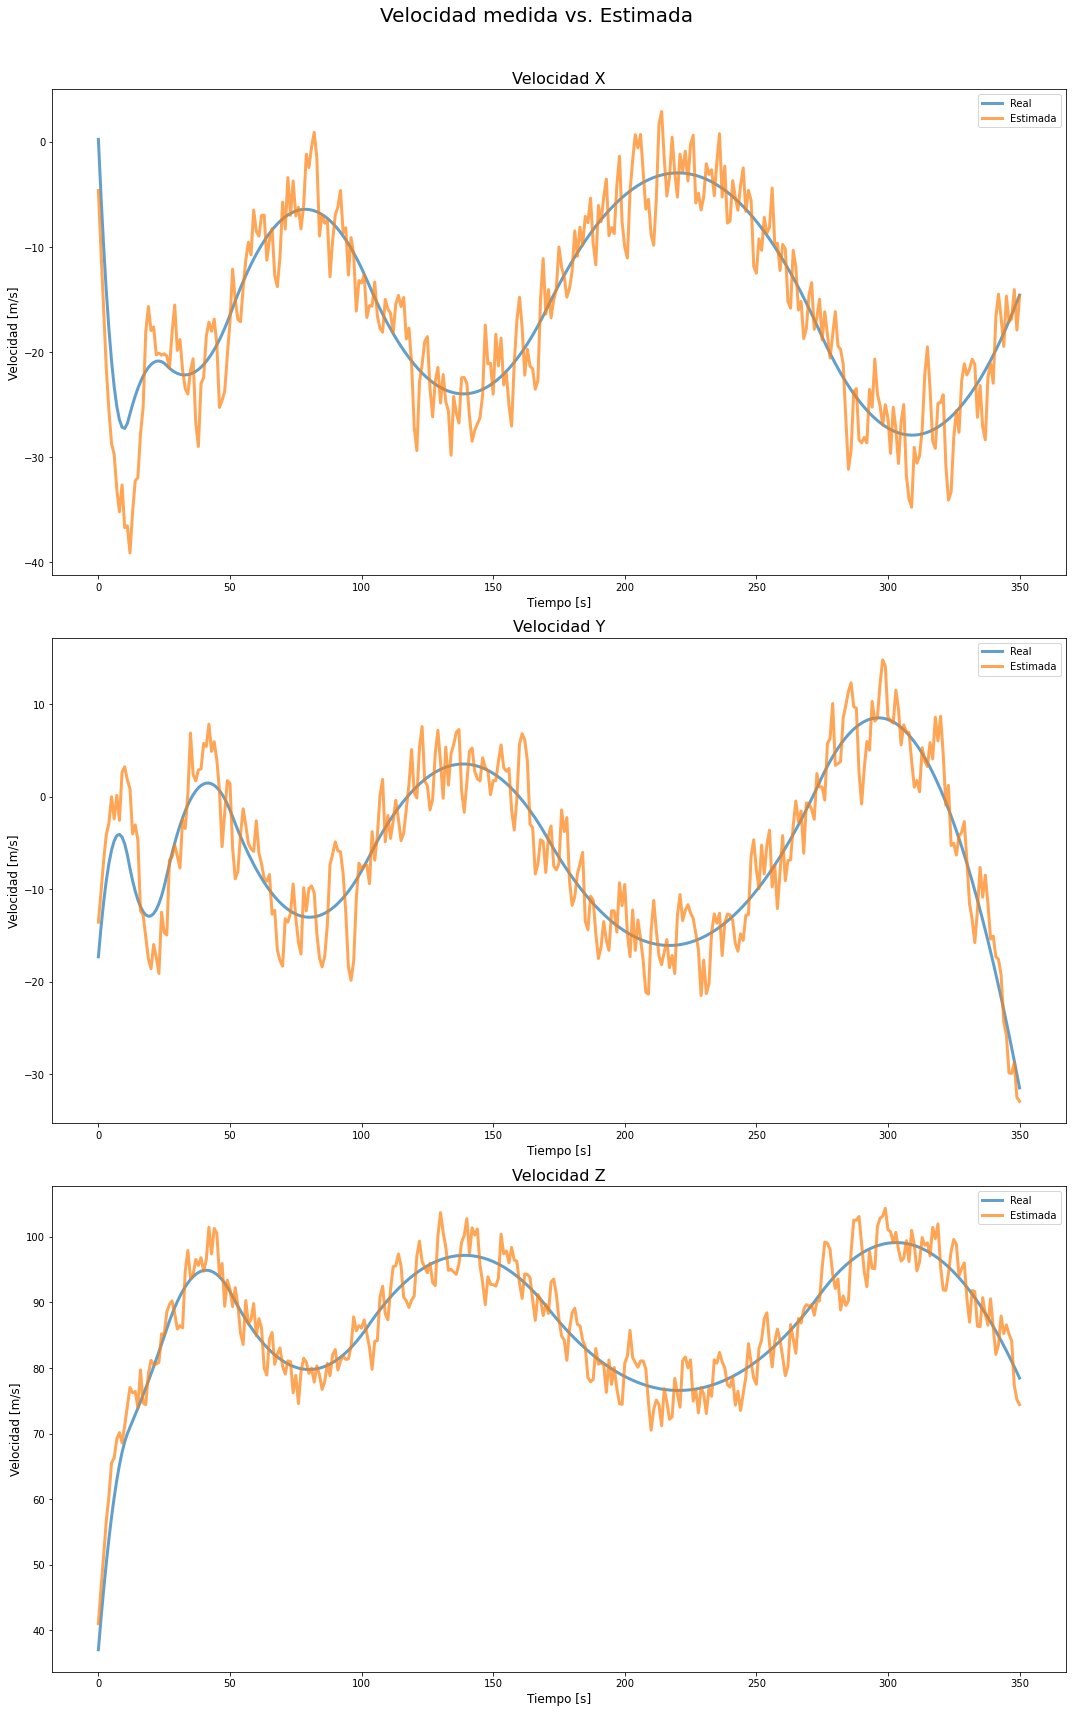

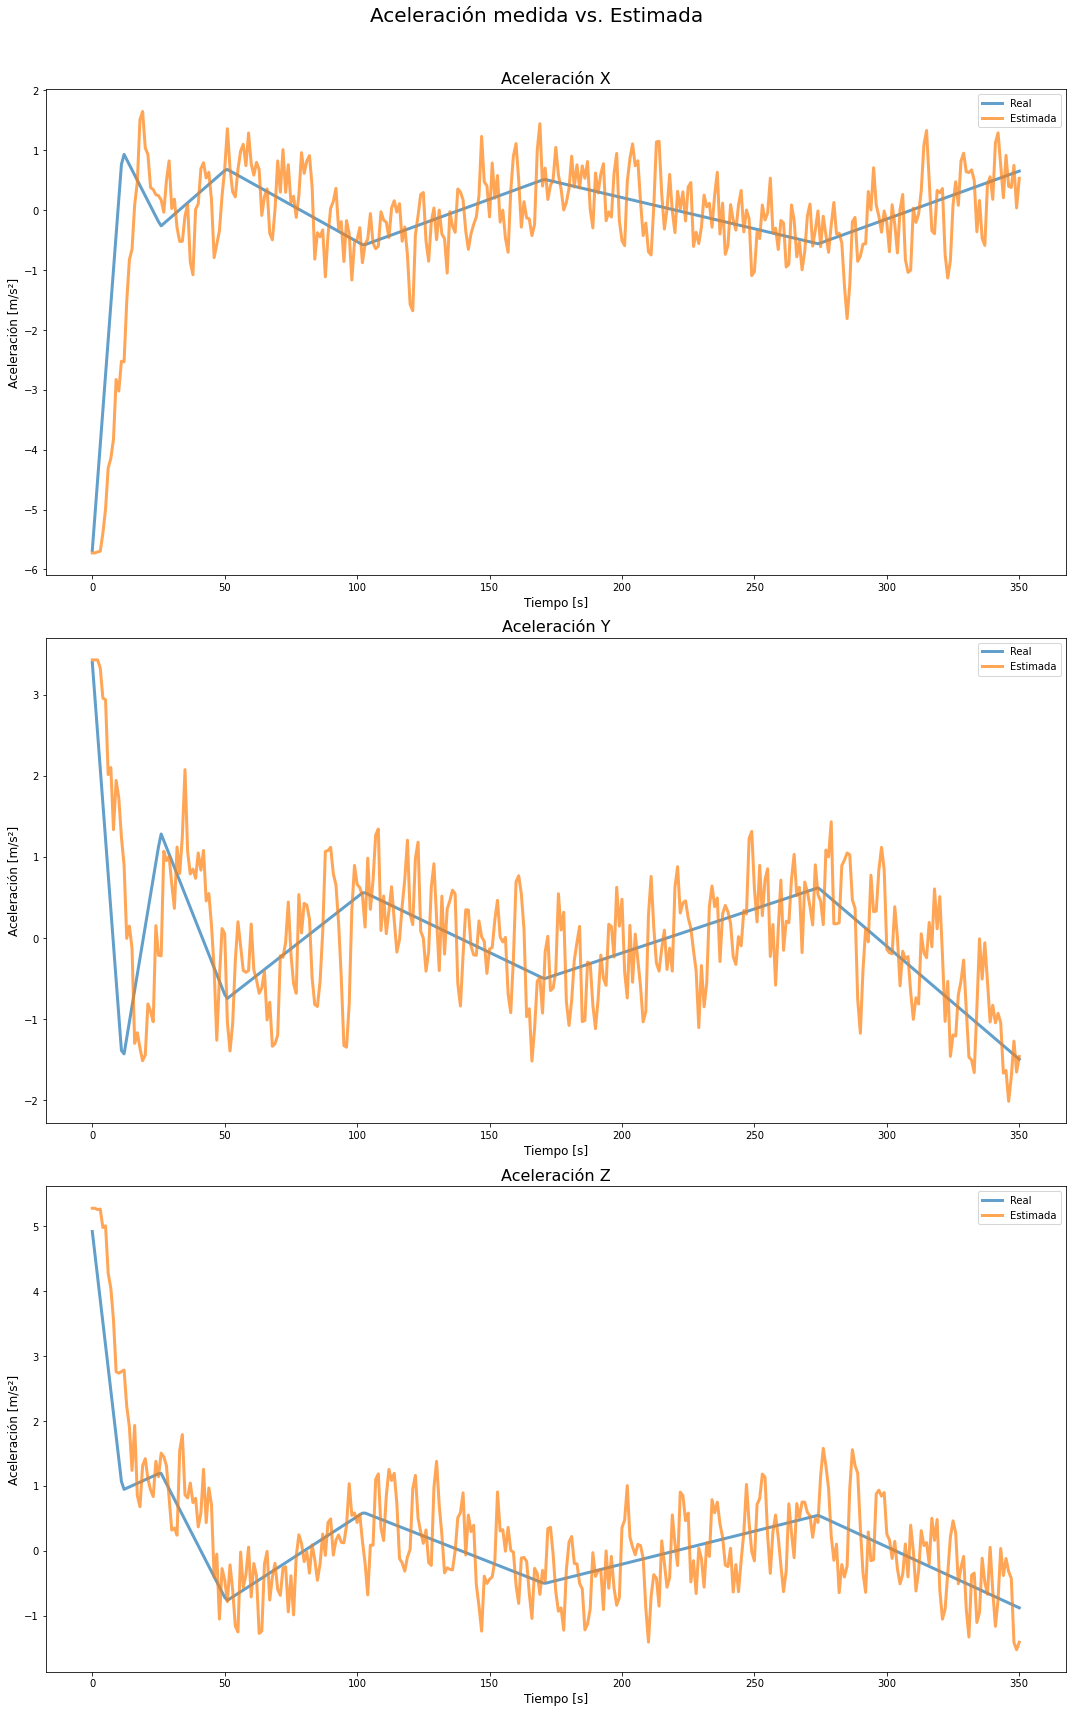

In [18]:
pos_pred_uniform, vel_pred_uniform, ace_pred_uniform = kalman(A, C, Q, R, x0, P0, pos_noise_uniform)

join_plot(np.array([pos, pos_pred_uniform]),
            plot_names=['Posición X','Posición Y','Posición Z'],
            y_label='Posición [m]',
            labels=['Real','Estimada'],
            main_title='Posición medida vs. Estimada')

join_plot(np.array([vel, vel_pred_uniform]),
            plot_names=['Velocidad X','Velocidad Y','Velocidad Z'],
            y_label='Velocidad [m/s]',
            labels=['Real','Estimada'],
            main_title='Velocidad medida vs. Estimada',
           )

join_plot(np.array([ace, ace_pred_uniform]),
            plot_names=['Aceleración X','Aceleración Y','Aceleración Z'],
            y_label='Aceleración [m/s²]',
            labels=['Real','Estimada'],
            main_title='Aceleración medida vs. Estimada')

### 5.3.- Estimaciones con mediciones de posición y velocidad con ruido gaussiano

En este caso, la matriz C se debe modifcar para agregar una nueva medición a las observaciones. Además, se agregan a R los términos correspondientes a la variancia del ruido en las velocidades.

In [19]:
# Matriz de obsevación
C = np.zeros([6,9])
for i in range(3):
    C[2*i,3*i] = 1
    C[2*i+1,3*i+1] = 1
print('C =')
print(C)

# Incerteza en las mediciones (covariancia del error en las mediciones)
R = np.diag([noise_gauss_d_pos**2, noise_gauss_d_vel**2, noise_gauss_d_pos**2,
             noise_gauss_d_vel**2,  noise_gauss_d_pos**2,  noise_gauss_d_vel**2])
print('R =')
print(R)

C =
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]]
R =
[[1.e+02 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 4.e-02 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+02 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 4.e-02 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 1.e+02 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 4.e-02]]


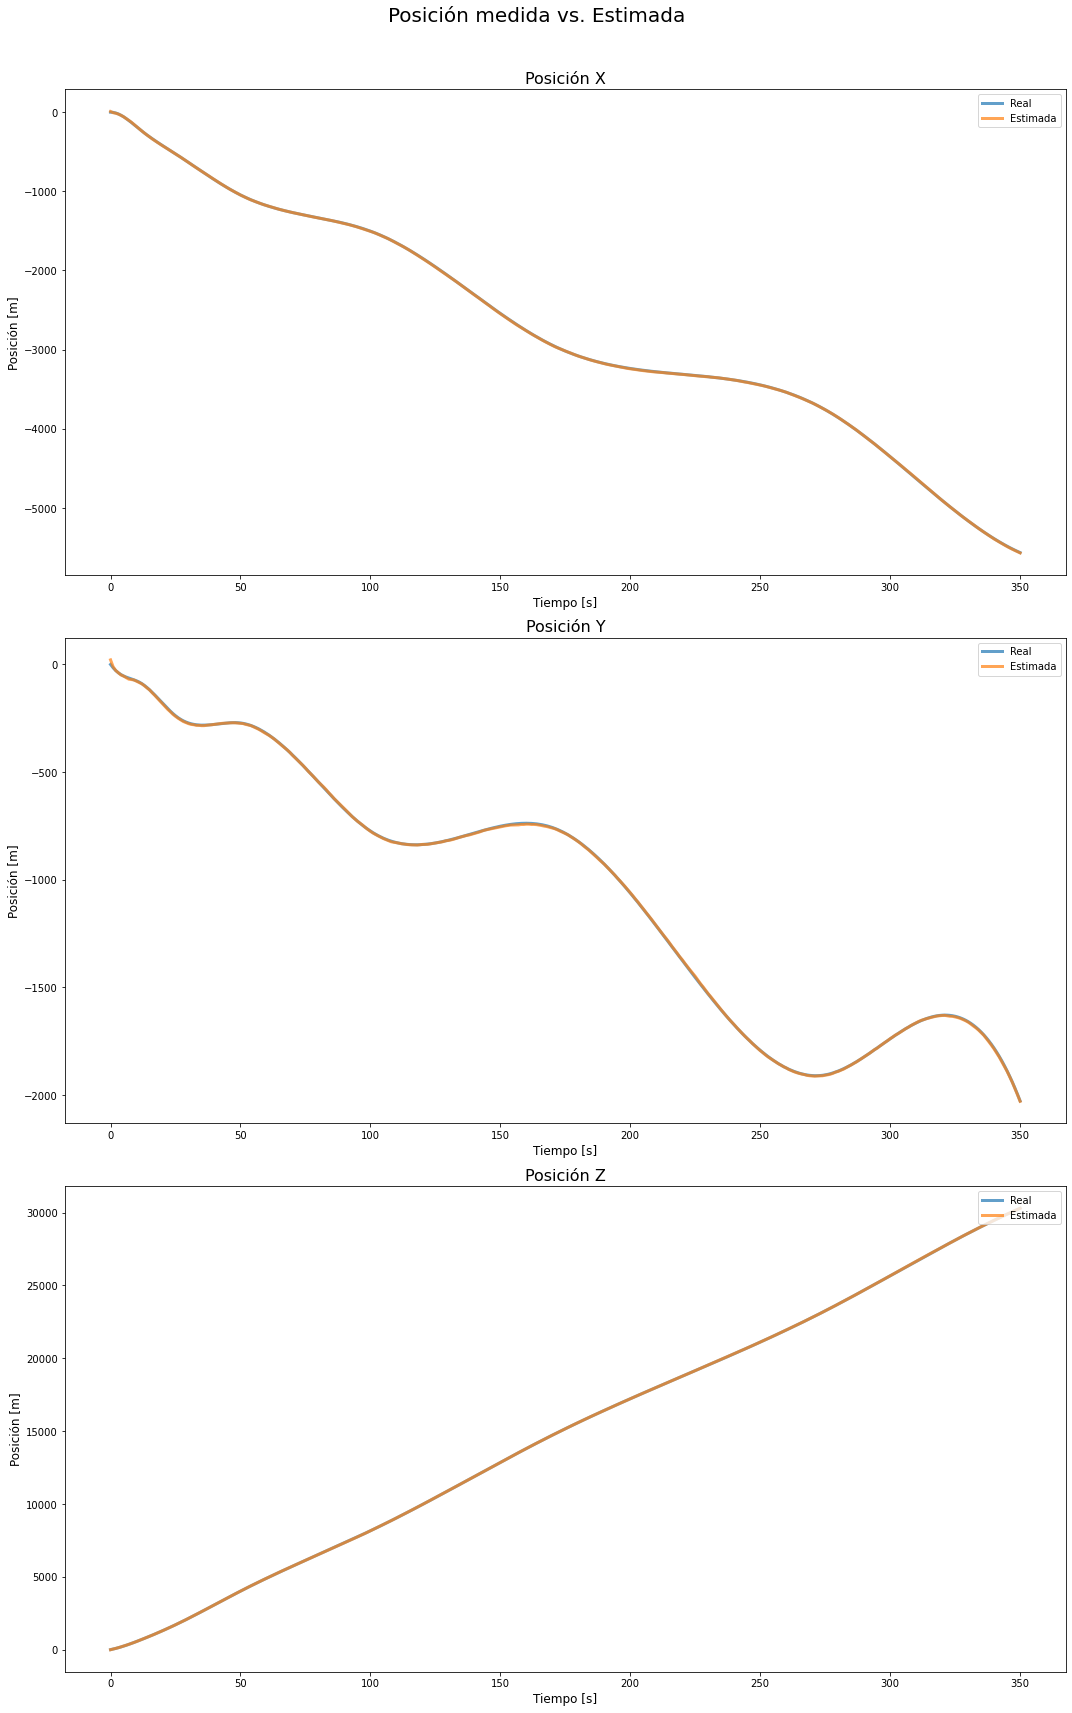

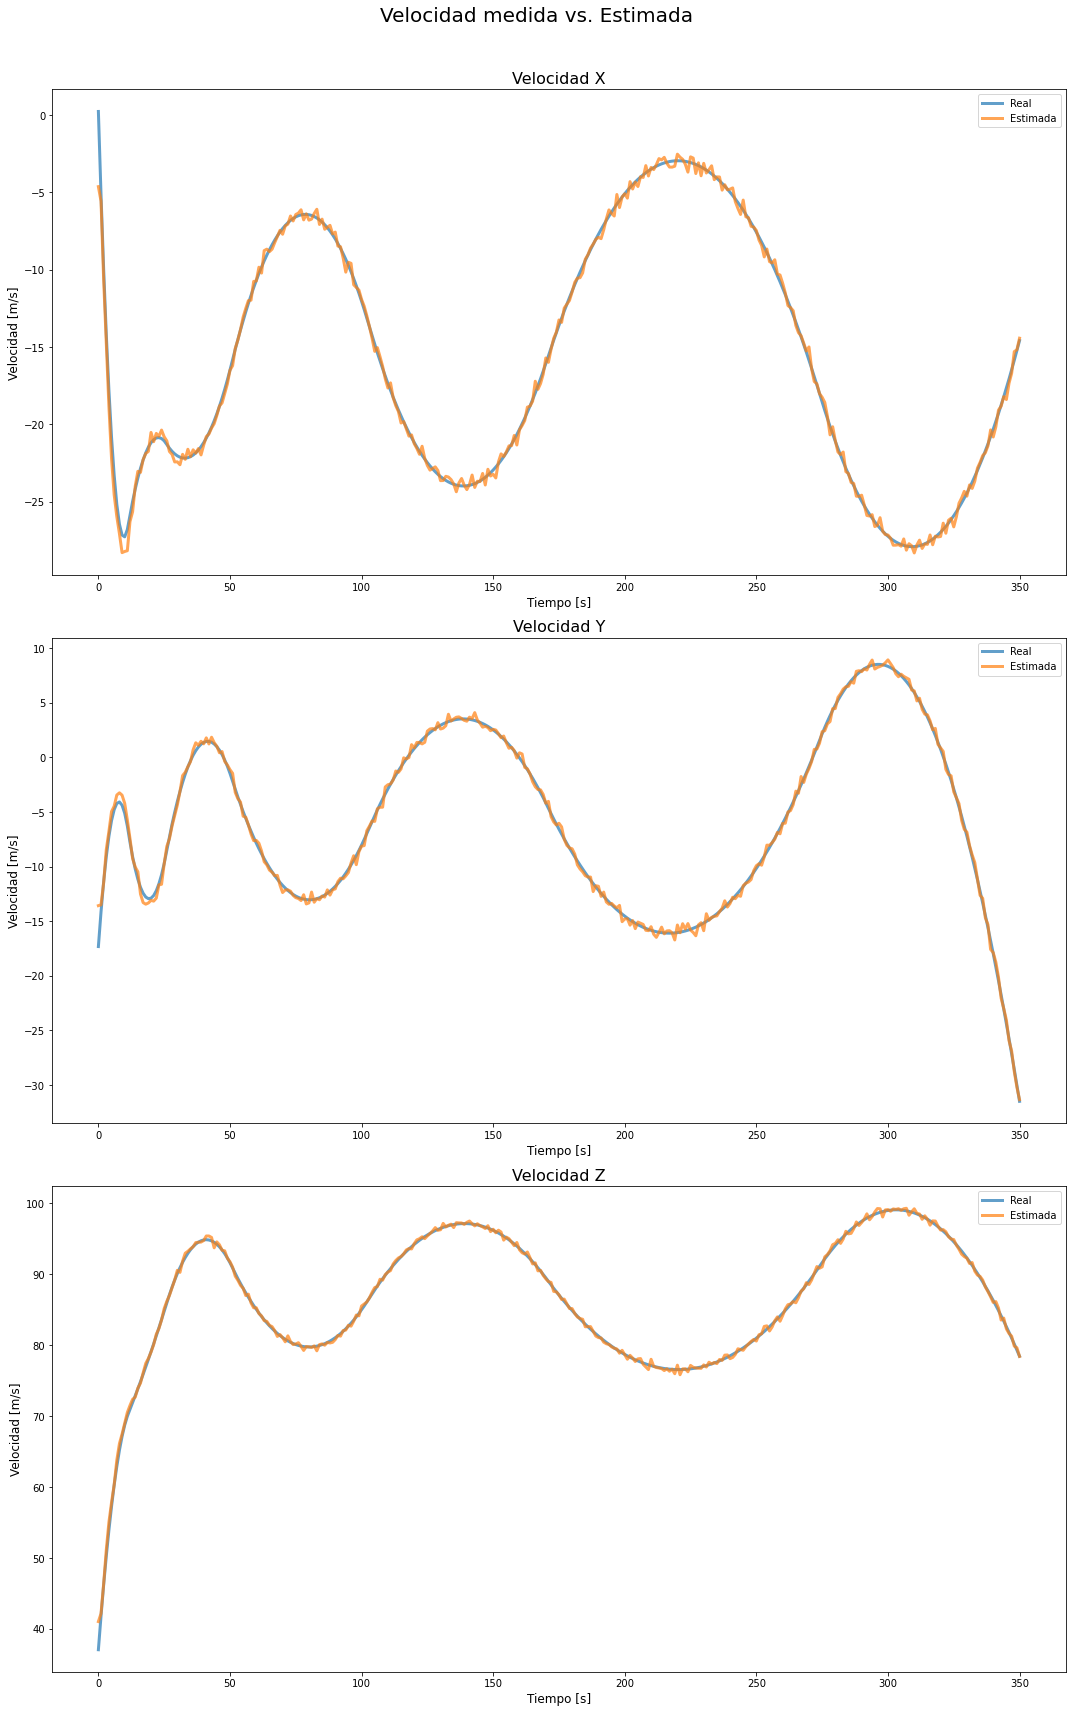

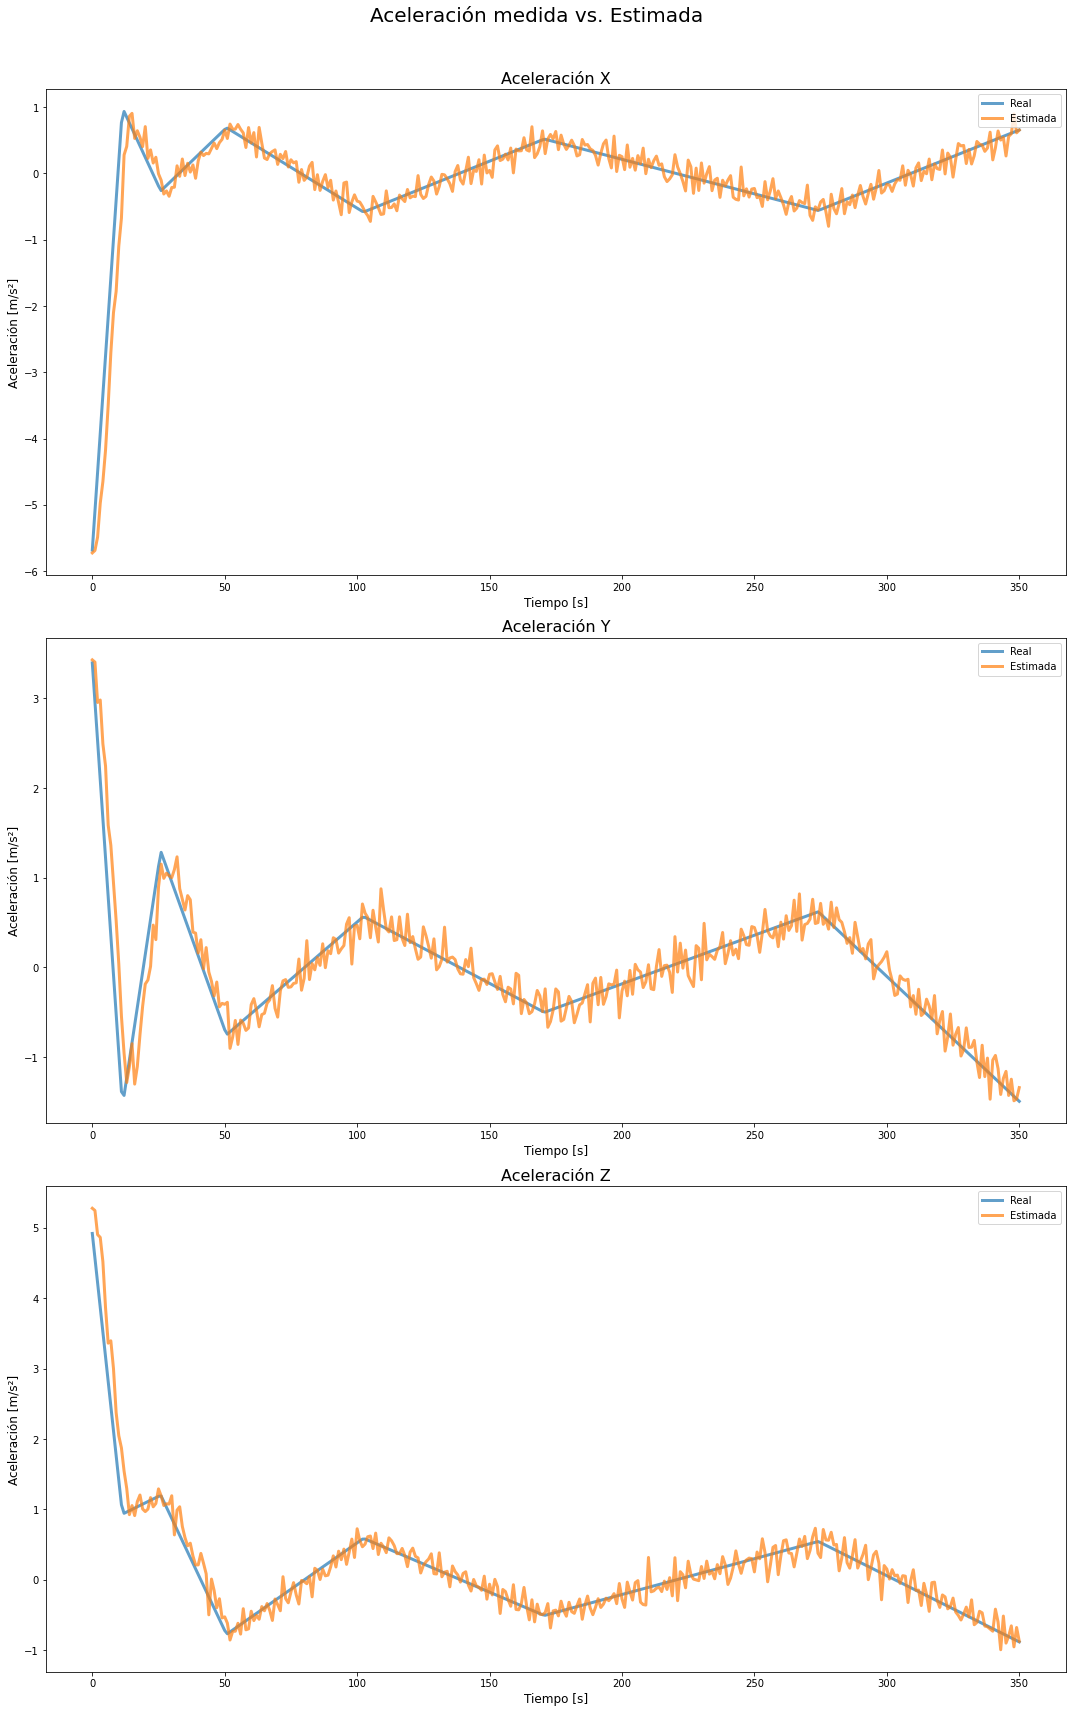

In [20]:
pos_pred_gauss_medV , vel_pred_gauss_medV, ace_pred_gauss_medV = kalman(A, C, Q, R, x0, 
                                                              P0, pos_noise_gauss, vel_noise_gauss)
join_plot(np.array([pos,pos_pred_gauss_medV]),
            plot_names=['Posición X','Posición Y','Posición Z'],
            y_label='Posición [m]',
            labels=['Real','Estimada'],
            main_title='Posición medida vs. Estimada')

join_plot(np.array([vel,vel_pred_gauss_medV]),
            plot_names=['Velocidad X','Velocidad Y','Velocidad Z'],
            y_label='Velocidad [m/s]',
            labels=['Real','Estimada'],
            main_title='Velocidad medida vs. Estimada',
           )

join_plot(np.array([ace,ace_pred_gauss_medV]),
            plot_names=['Aceleración X','Aceleración Y','Aceleración Z'],
            y_label='Aceleración [m/s²]',
            labels=['Real','Estimada'],
            main_title='Aceleración medida vs. Estimada')

# 6.- Comparación de resultados

A continuación se grafica la evolución de los errores de posición, velocidad y aceleración a lo largo del tiempo para cada caso analizado. Este error es calculado como el valor absoluto de la diferencia entre el valor real de la variable y el valor estimado por el filtro:

<img src="./img/err_abs.png" alt="mape" style="width: 200px;"/>

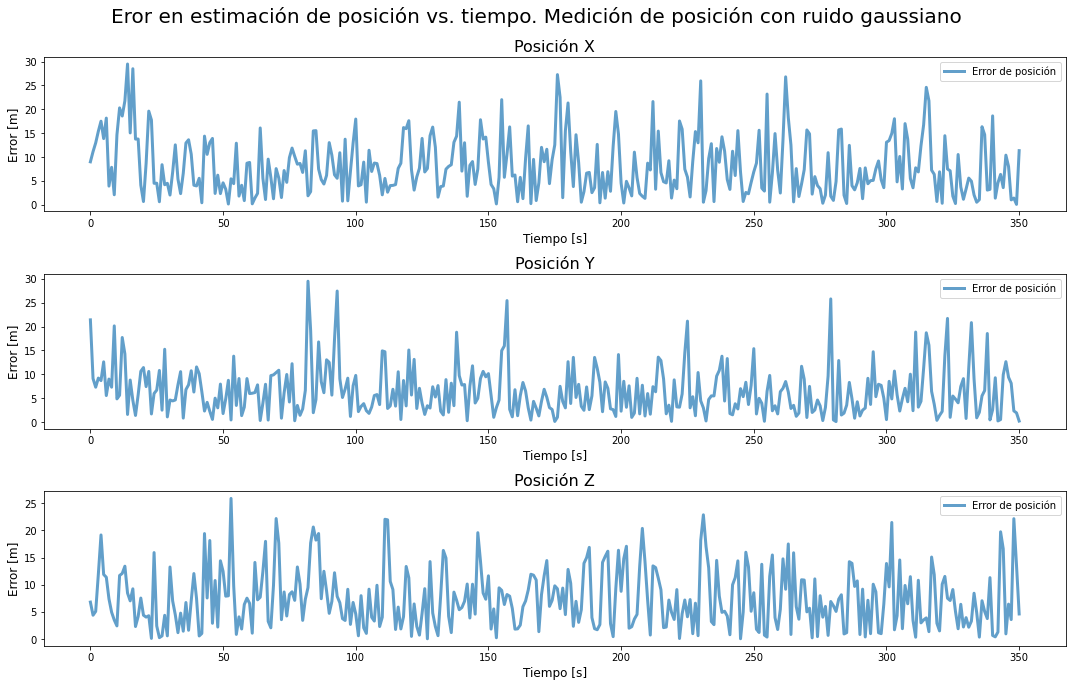

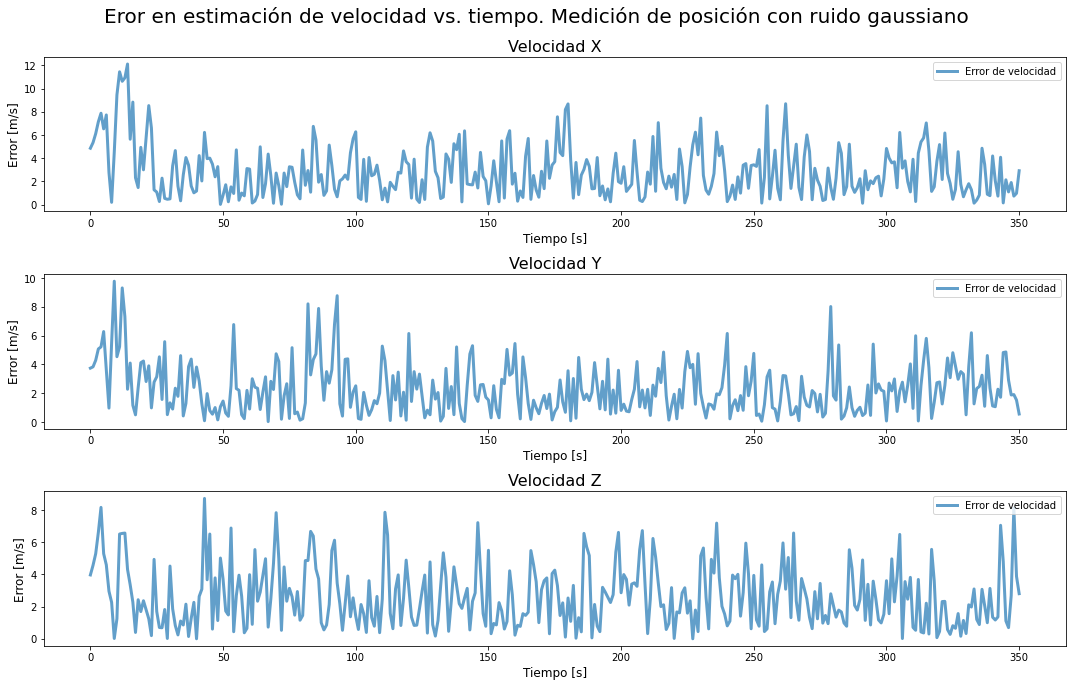

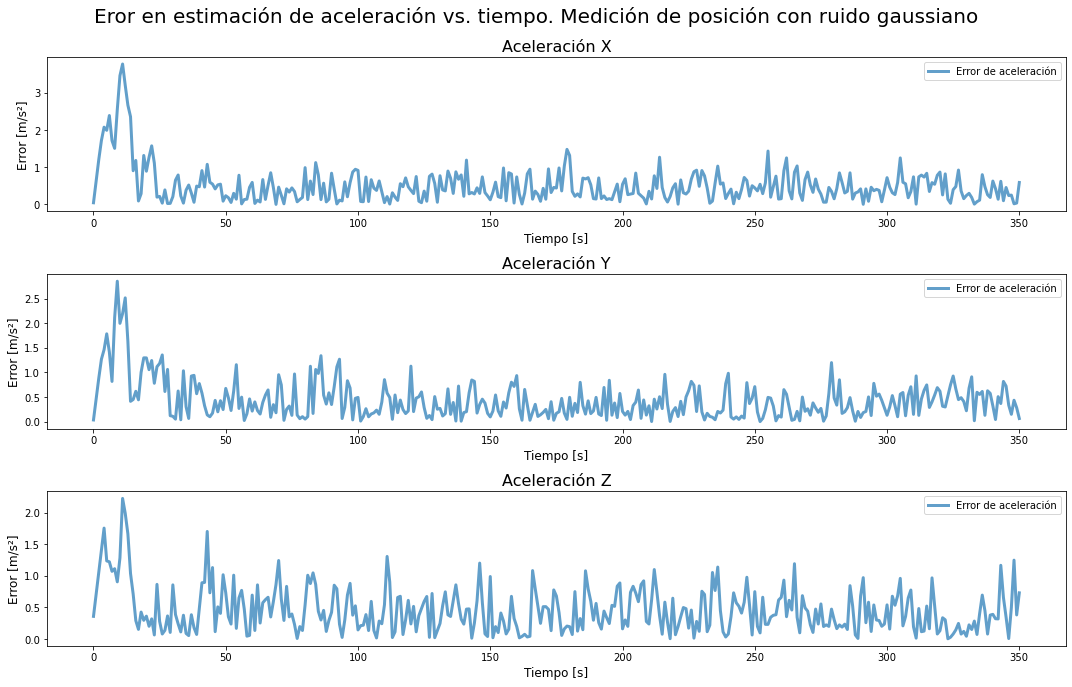

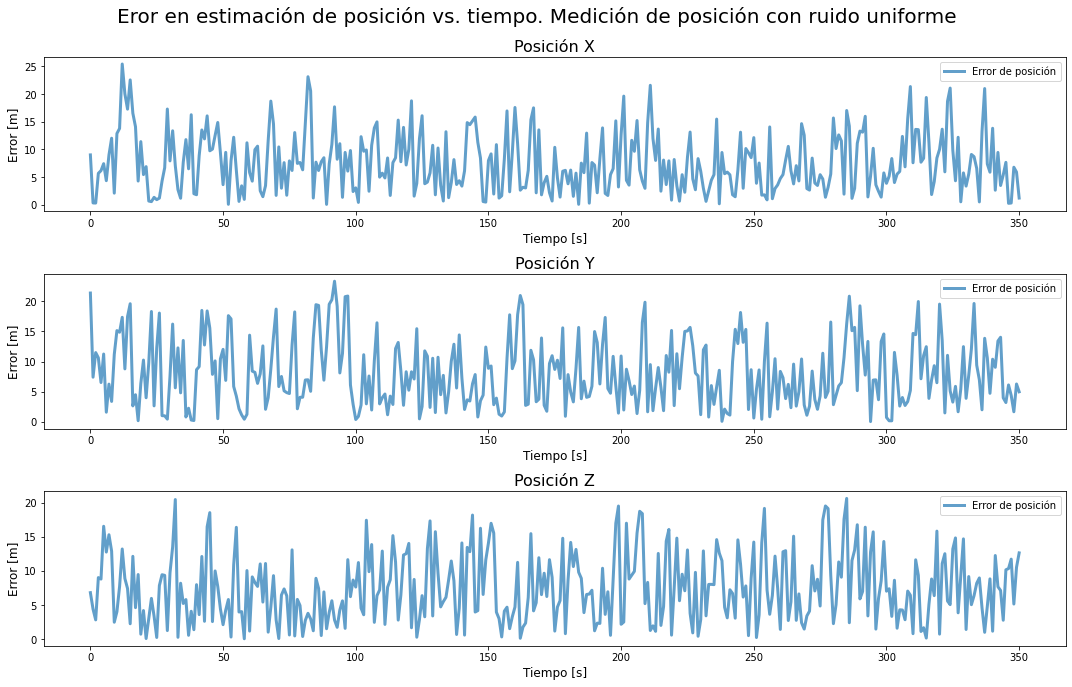

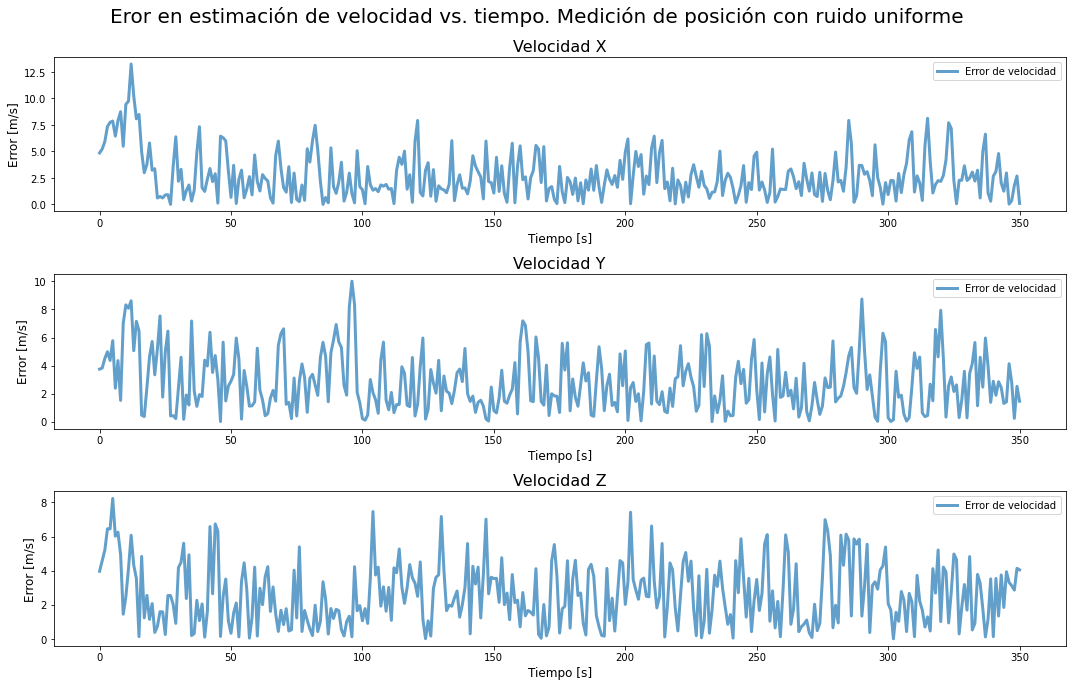

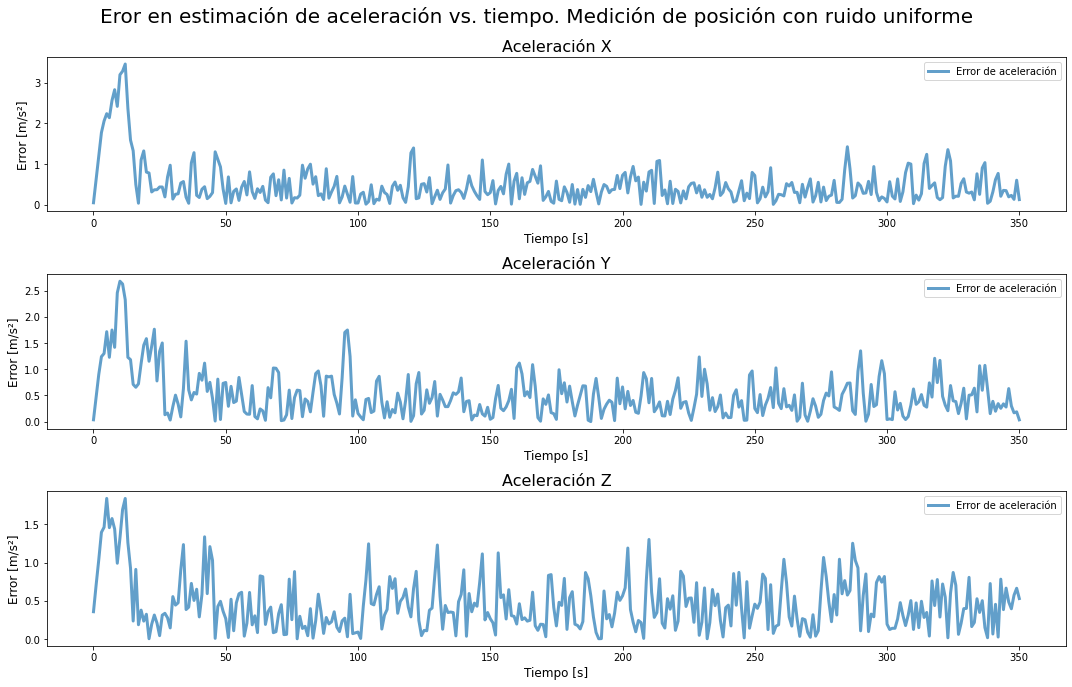

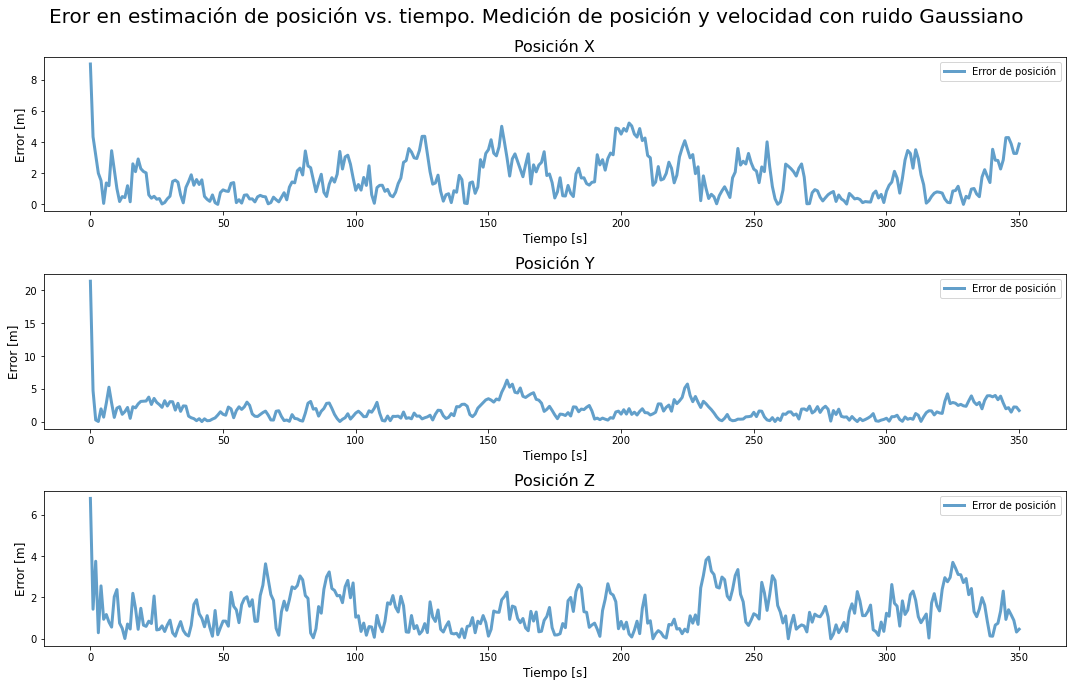

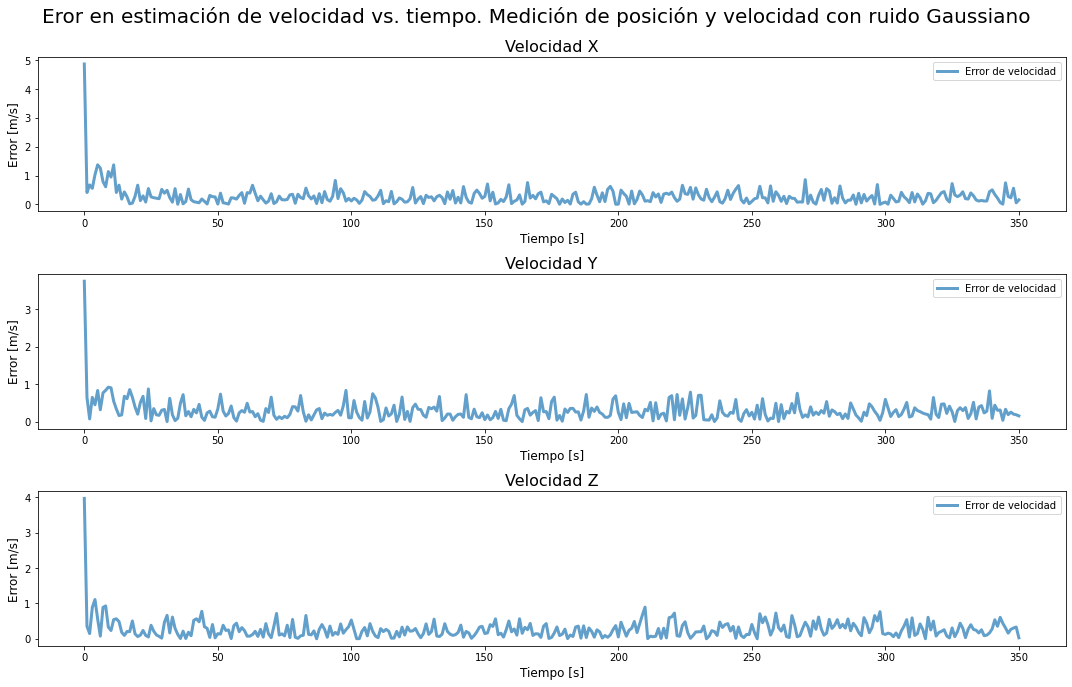

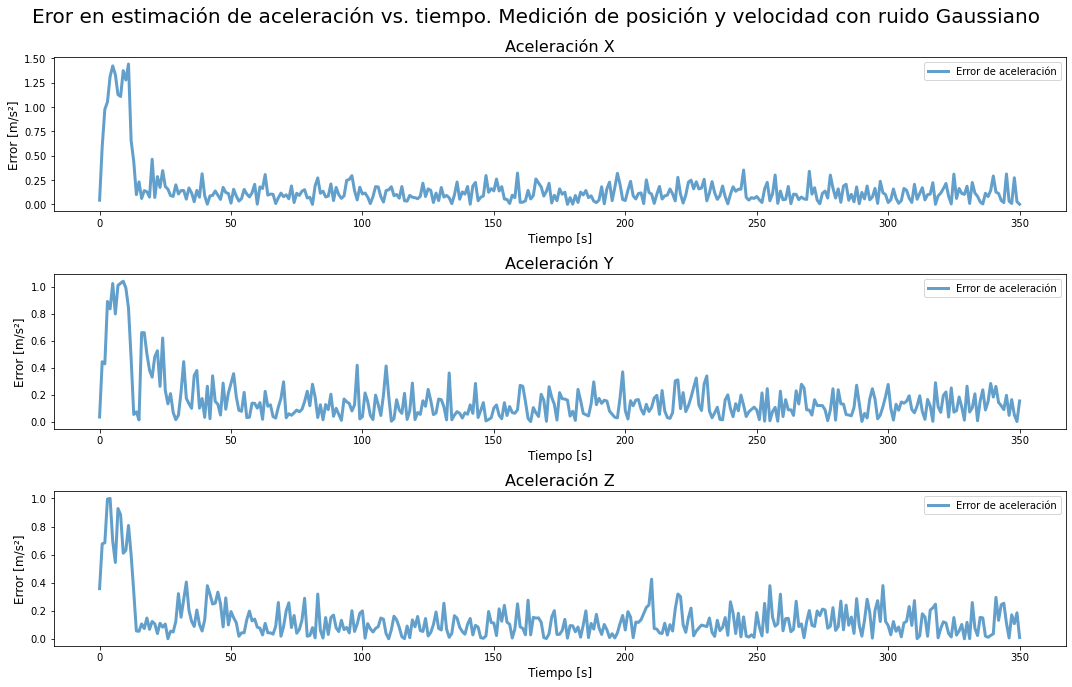

In [21]:
# Medición de posición con ruido gaussiano
join_plot(np.array([abs(pos-pos_pred_gauss)]),
            plot_names=['Posición X','Posición Y','Posición Z'],
            y_label='Error [m]',
            labels=['Error de posición'],
            main_title='Eror en estimación de posición vs. tiempo. Medición de posición con ruido gaussiano',
            layout='thin')
join_plot(np.array([abs(vel-vel_pred_gauss)]),
            plot_names=['Velocidad X','Velocidad Y','Velocidad Z'],
            y_label='Error [m/s]',
            labels=['Error de velocidad'],
            main_title='Eror en estimación de velocidad vs. tiempo. Medición de posición con ruido gaussiano',
            layout='thin')
join_plot(np.array([abs(ace-ace_pred_gauss)]),
            plot_names=['Aceleración X','Aceleración Y','Aceleración Z'],
            y_label='Error [m/s²]',
            labels=['Error de aceleración'],
            main_title='Eror en estimación de aceleración vs. tiempo. Medición de posición con ruido gaussiano',
            layout='thin')

# Medición de posición con ruido uniforme
join_plot(np.array([abs(pos-pos_pred_uniform)]),
            plot_names=['Posición X','Posición Y','Posición Z'],
            y_label='Error [m]',
            labels=['Error de posición'],
            main_title='Eror en estimación de posición vs. tiempo. Medición de posición con ruido uniforme',
            layout='thin')
join_plot(np.array([abs(vel-vel_pred_uniform)]),
            plot_names=['Velocidad X','Velocidad Y','Velocidad Z'],
            y_label='Error [m/s]',
            labels=['Error de velocidad'],
            main_title='Eror en estimación de velocidad vs. tiempo. Medición de posición con ruido uniforme',
            layout='thin')
join_plot(np.array([abs(ace-ace_pred_uniform)]),
            plot_names=['Aceleración X','Aceleración Y','Aceleración Z'],
            y_label='Error [m/s²]',
            labels=['Error de aceleración'],
            main_title='Eror en estimación de aceleración vs. tiempo. Medición de posición con ruido uniforme',
            layout='thin')

# Medición de posición y velocidad con ruido gaussiano
join_plot(np.array([abs(pos-pos_pred_gauss_medV)]),
            plot_names=['Posición X','Posición Y','Posición Z'],
            y_label='Error [m]',
            labels=['Error de posición'],
            main_title='Eror en estimación de posición vs. tiempo. Medición de posición y velocidad con ruido Gaussiano',
            layout='thin')
join_plot(np.array([abs(vel-vel_pred_gauss_medV)]),
            plot_names=['Velocidad X','Velocidad Y','Velocidad Z'],
            y_label='Error [m/s]',
            labels=['Error de velocidad'],
            main_title='Eror en estimación de velocidad vs. tiempo. Medición de posición y velocidad con ruido Gaussiano',
            layout='thin')
join_plot(np.array([abs(ace-ace_pred_gauss_medV)]),
            plot_names=['Aceleración X','Aceleración Y','Aceleración Z'],
            y_label='Error [m/s²]',
            labels=['Error de aceleración'],
            main_title='Eror en estimación de aceleración vs. tiempo. Medición de posición y velocidad con ruido Gaussiano',
            layout='thin')

Podemos ver que en general, el error arranca en un valor relativamente alto pero rápidamente decrese y oscila entre valores menores. En la mayoría de los casos, podemos considerar que a partir de t=30s el error ya llegó a sus valores finales.

Por otro lado, si observamos las gráficas de los dos primeros casos, se puede ver que el comportamiento de las cruvas de error son similares y oscilan etre aproximádamente los mismos valores. Es decir que los errores obtenidos en las estimaciones a partir de mediciones con ruido de distribución uniforme o gaussiana, son similares.

Sin embargo, al agregar la medición de velocidad los resultados mejoran notablemente, no solo en los valores de velocidad y aceleración, sino también en los de posición.

A continuación se calcula el error cuadrático medio (RMSE) de cada gráfica para tener una visión de los resultados de manera global.

In [22]:
def get_column(my_list,n):
    # Retorna la primer columna de una lista bidimensional.
    return [i[n] for i in my_list]

Variable      Ruido Gaussiano (pos)    Ruido Uniforme (pos)    Ruido Gaussiano (pos y vel)
----------  -----------------------  ----------------------  -----------------------------
Pos X                        10.105                   9.261                          2.135
Pos Y                         8.3                     9.857                          2.375
Pos Z                         9.257                   8.999                          1.584
Vel X                         3.615                   3.462                          0.434
Vel Y                         2.933                   3.473                          0.403
Vel Z                         3.252                   3.206                          0.386
Ace X                         0.713                   0.693                          0.258
Ace Y                         0.597                   0.664                          0.23
Ace Z                         0.582                   0.574                          0.202


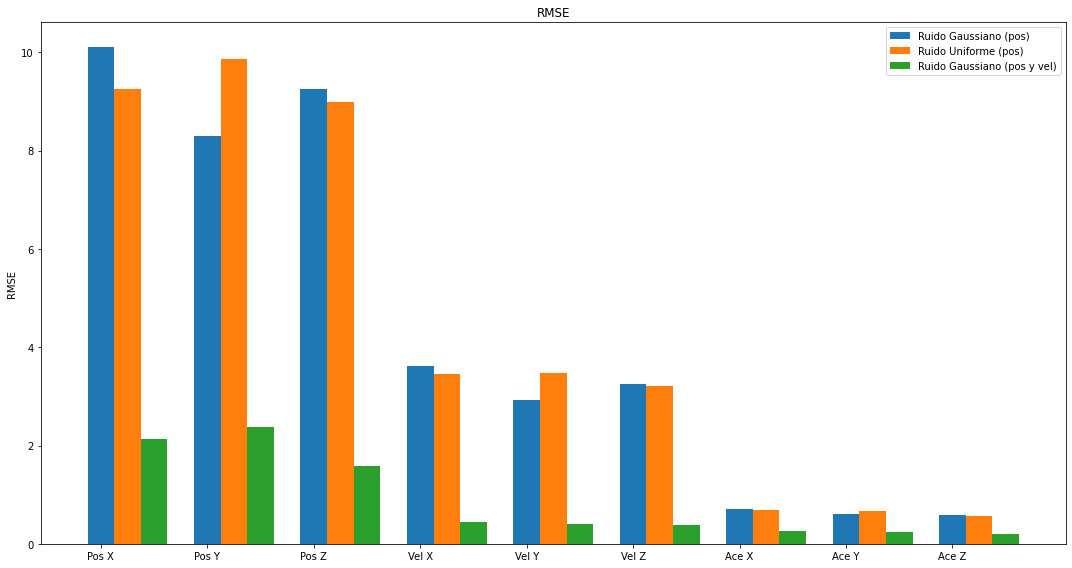

In [23]:
rmse_total = []
for i in range(3):
    row = []
    row.append(rmse(pos[:,i],pos_pred_gauss[:,i]))
    row.append(rmse(pos[:,i],pos_pred_uniform[:,i]))
    row.append(rmse(pos[:,i],pos_pred_gauss_medV[:,i]))
    rmse_total.append(row)
for i in range(3):
    row = []
    row.append(rmse(vel[:,i],vel_pred_gauss[:,i]))
    row.append(rmse(vel[:,i],vel_pred_uniform[:,i]))
    row.append(rmse(vel[:,i],vel_pred_gauss_medV[:,i]))
    rmse_total.append(row)
for i in range(3):
    row = []
    row.append(rmse(ace[:,i],ace_pred_gauss[:,i]))
    row.append(rmse(ace[:,i],ace_pred_uniform[:,i]))
    row.append(rmse(ace[:,i],ace_pred_gauss_medV[:,i]))
    rmse_total.append(row)

labels_col = ["Pos X", "Pos Y", "Pos Z",
              "Vel X", "Vel Y", "Vel Z",
              "Ace X", "Ace Y", "Ace Z"]
rmse_total_table = []
for i in range (9):
    row = []
    row.append(labels_col[i])
    d = np.array(rmse_total[i]).astype(np.float)
    row[1:3] = np.round(d,3)
    rmse_total_table.append(row)

print (tabulate(rmse_total_table, headers=["Variable", "Ruido Gaussiano (pos)", 
                               "Ruido Uniforme (pos)", "Ruido Gaussiano (pos y vel)"]))

rmse_gauss = get_column(rmse_total,0)
rmse_uniform = get_column(rmse_total,1)
rmse_gauss_medV = get_column(rmse_total,2)

x = np.arange(len(labels_col))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(15,8))
rects1 = ax.bar(x + 0*width, rmse_gauss[0:9], width, label='Ruido Gaussiano (pos)')
rects2 = ax.bar(x + 1*width, rmse_uniform[0:9], width, label='Ruido Uniforme (pos)')
rects3 = ax.bar(x + 2*width, rmse_gauss_medV[0:9], width, label='Ruido Gaussiano (pos y vel)')

ax.set_ylabel('RMSE')
ax.set_title('RMSE')
ax.set_xticks(x)
ax.set_xticklabels(labels_col)
ax.legend()

fig.tight_layout()

plt.show()

Vemos que los resultados se condicen con lo comentado anteriormente. El RMSE para el caso de medición de posición con ruido gaussiano, es prácticamente igual al de medición con ruido uniforme. Cabe destacar que, si bien el error en las estimaciones de velocidad y aceleración para los dos primeros casos es alto, estamos obteniendo dos variables nuevas a partir de la medición de una tercera. Es decir que, a pesar de tener un error alto, se logra conocer los valores de variables que no podemos medir.

Al agregar la medición de velocidad, los resultados mejoran para todas las variables analizadas. En la siguiente celda, puede verse el porcentaje de mejora para cada varable.

Nota: Si bien los valores absolutos de RMSE para al aceleración son menores que para la posición, hay que tener en cuenta que son relativos a la magnitud medida.

In [24]:
rmse_medP = np.array(rmse_gauss).astype(np.float)
rmse_medV = np.array(rmse_gauss_medV).astype(np.float)
rmse_result = np.round((rmse_medV/rmse_medP)*100,1)
for i in range(len(labels_col)):
    print('Mejora de RMSE para ' + str(labels_col[i]) + ' = ' + str(rmse_result[i]) + '%')

Mejora de RMSE para Pos X = 21.1%
Mejora de RMSE para Pos Y = 28.6%
Mejora de RMSE para Pos Z = 17.1%
Mejora de RMSE para Vel X = 12.0%
Mejora de RMSE para Vel Y = 13.7%
Mejora de RMSE para Vel Z = 11.9%
Mejora de RMSE para Ace X = 36.2%
Mejora de RMSE para Ace Y = 38.5%
Mejora de RMSE para Ace Z = 34.6%


Finalmente, se grafica la posición medida con ruido gaussiano, superpueta por la estmada por el filtro, tomando como entrada medición de posición y velocidad. Puede verse en estas gráficas, que la salida del filtro logra eliminar en gran medida el ruido de la medición.

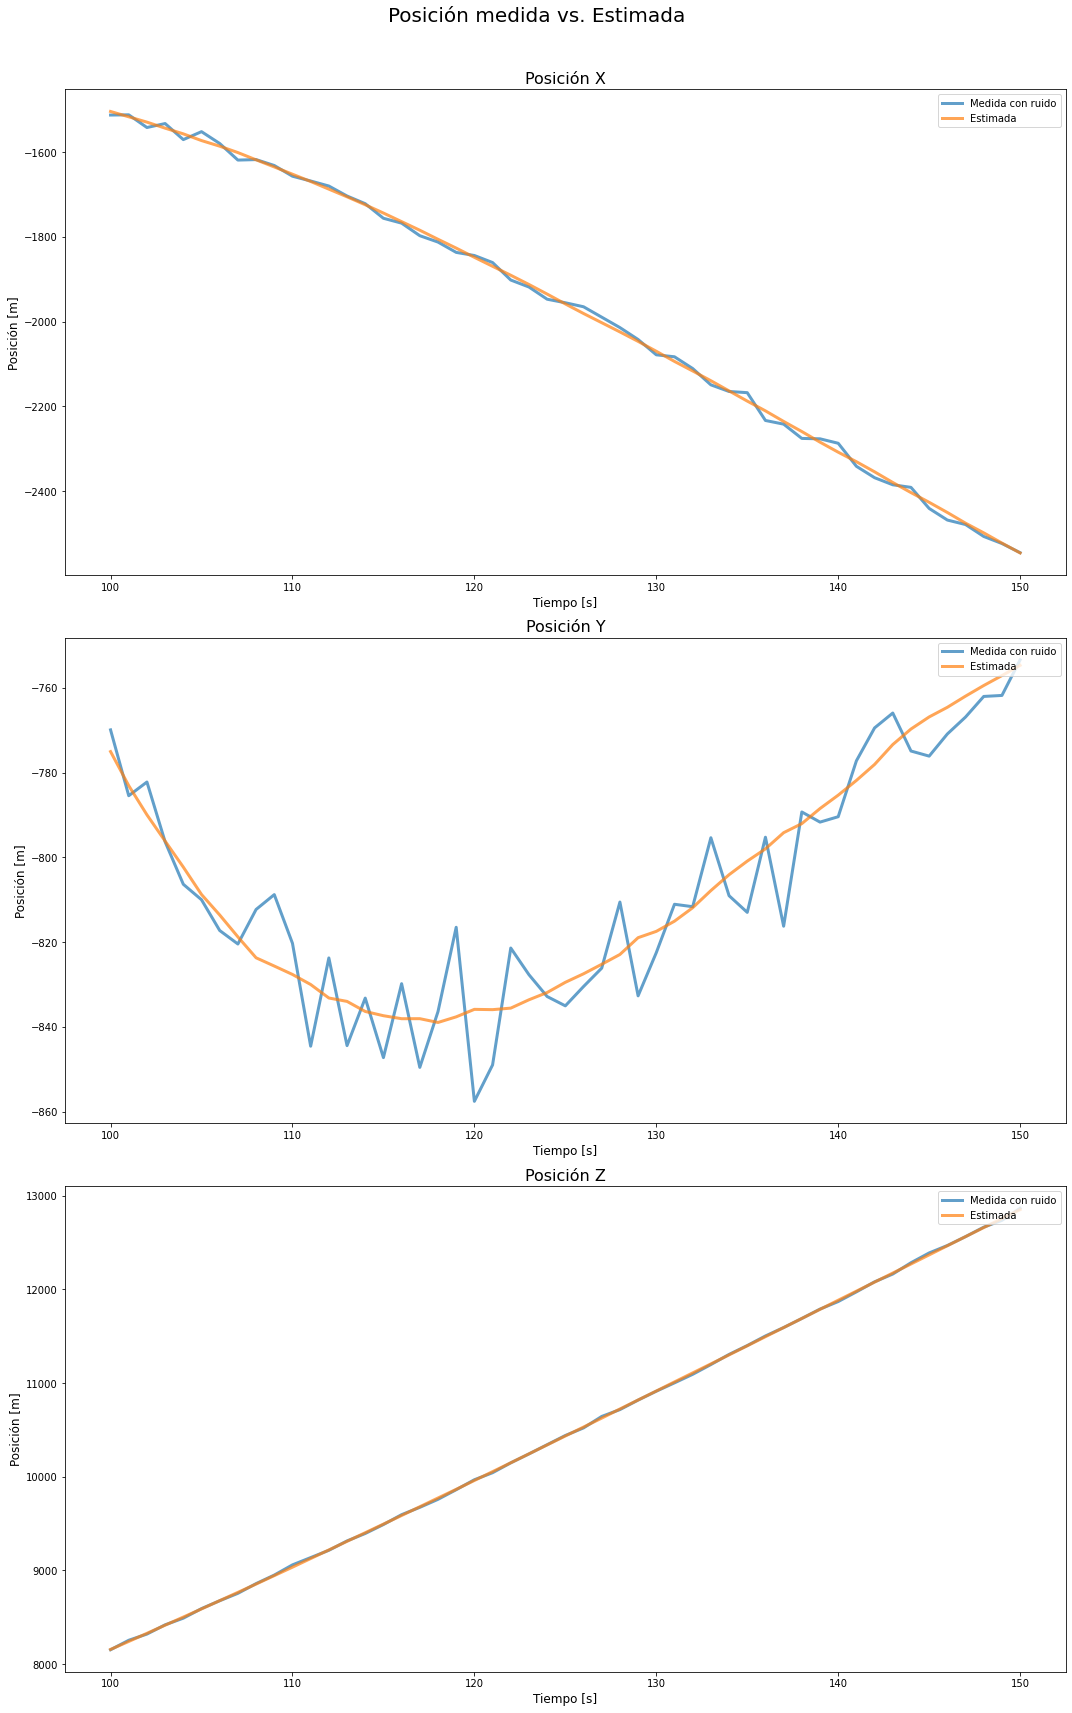

In [25]:
join_plot(np.array([pos_noise_gauss,pos_pred_gauss_medV]),
            plot_names=['Posición X','Posición Y','Posición Z'],
            y_label='Posición [m]',
            labels=['Medida con ruido','Estimada'],
            main_title='Posición medida vs. Estimada',
            zoom = [100,150])

# 7.- Conclusiones

En este trabajo desarrollado, se ha desarrollado una aplicación básica del filtro de kalman. Por un lado, el filtro permite predecir la posición y velocida de un objeto, a partir de la medición de su posición. Esta es una característica muy últil ya que no siempre es posible medir la velocidad y aceleración de los objetos.

Por otro lado, se comprobó que mediante su uso se puede obtener una mejor estimación de las variables, que las mediciones directas tomada de los sesores. Además, permite integrar las mediciones de distintas variables, como posición y velocidad, y obtener como resultado una mejor estimación de ambas. 

Finalmente, se comprobó que los resultados del filtro no dependen de la distribución del ruido en la medición. Sin embargo, las estmiaciones mejoran notablemente cuando se agregan más mediciones.